In [1]:
# Asegura versiones compatibles al abrir/ejecutar el notebook
%pip -q install pandas==2.2.3 pandas-datareader==0.10.0


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. LIBRERÍAS Y BIBLIOTECAS

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import pandas_datareader.data as web
import missingno as msno
import matplotlib.pyplot as plt
import calendar
import holidays
from datetime import timedelta
import os
import pandas_ta as ta
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# 2. INGESTIÓN O CARGA DE DATOS 

## 2.1 DATASET DE ETFS

In [12]:
# Lista de tickers de los ETFs a descargar 
lista_etfs = ["SPY", "DIA", "QQQ", "XLK", "IWV"]

# DataSet vacío para almacenar los precios de cierre de los ETFs
data_etfs = pd.DataFrame()
fecha_inicio = "2001-01-16"
fecha_fin = "2026-01-21"

# Descarga de los precios de cierre de cada ETF y agregarlos al DataFrame
for ticker in lista_etfs:
    precios_cierre = yf.Ticker(ticker).history(start=fecha_inicio, end=fecha_fin)['Close']
    data_etfs[ticker] = precios_cierre

# Mostrar DataSet resultante
data_etfs

,SPY,DIA,QQQ,XLK,IWV
Date,,,,,
2001-01-16 00:00:00-05:00,84.563812,61.707676,52.353550,12.898789,48.284355
2001-01-17 00:00:00-05:00,84.951698,61.435944,53.950413,13.294602,48.532398
2001-01-18 00:00:00-05:00,85.797165,61.870735,56.220322,13.993094,49.193825
2001-01-19 00:00:00-05:00,85.309814,61.268711,56.009182,14.185179,48.842438
2001-01-22 00:00:00-05:00,85.876770,61.595207,56.061974,13.923237,48.852764
...,...,...,...,...,...
2026-01-13 00:00:00-05:00,693.770020,491.761932,626.239990,146.479996,394.670013
2026-01-14 00:00:00-05:00,690.359985,491.402039,619.549988,144.699997,393.130005
2026-01-15 00:00:00-05:00,692.239990,494.301025,621.780029,145.460007,394.309998


In [13]:
# Creamos un DataSet con todas las fechas de luenes a viernes, incluyendo los días festivos
fechas = pd.date_range(start=data_etfs.index.min(), end=data_etfs.index.max(), freq='D')
fechas = fechas[fechas.weekday < 5]
data_etfs = data_etfs.reindex(fechas)

# Mostrar DataSet resultante
data_etfs

,SPY,DIA,QQQ,XLK,IWV
2001-01-16 00:00:00-05:00,84.563812,61.707676,52.353550,12.898789,48.284355
2001-01-17 00:00:00-05:00,84.951698,61.435944,53.950413,13.294602,48.532398
2001-01-18 00:00:00-05:00,85.797165,61.870735,56.220322,13.993094,49.193825
2001-01-19 00:00:00-05:00,85.309814,61.268711,56.009182,14.185179,48.842438
2001-01-22 00:00:00-05:00,85.876770,61.595207,56.061974,13.923237,48.852764
...,...,...,...,...,...
2026-01-14 00:00:00-05:00,690.359985,491.402039,619.549988,144.699997,393.130005
2026-01-15 00:00:00-05:00,692.239990,494.301025,621.780029,145.460007,394.309998
2026-01-16 00:00:00-05:00,691.659973,493.420013,621.260010,145.619995,394.010010
2026-01-19 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN


- SPY (SPDR S&P 500 ETF Trust)
Es el ETF más antiguo y negociado del mundo. Su objetivo es replicar el índice S&P 500, lo que significa que invierte en las 500 empresas más grandes y sólidas de EE. UU. Es la herramienta estándar para quienes buscan invertir en la economía estadounidense en general con alta liquidez.

- QQQ (Invesco QQQ Trust)
Este fondo sigue el índice Nasdaq-100, que agrupa a las 100 empresas no financieras más importantes que cotizan en el mercado Nasdaq. Tiene un enfoque muy fuerte en tecnología e innovación (como Apple, Microsoft y Nvidia), siendo el favorito de quienes buscan crecimiento a largo plazo.

- IWM (iShares Russell 2000 ETF)
A diferencia de los anteriores, el IWM se enfoca en empresas de pequeña capitalización (Small Caps). Al seguir el índice Russell 2000, ofrece exposición a compañías más pequeñas que tienen un alto potencial de crecimiento, aunque suelen ser más volátiles que las grandes corporaciones.

- XLK (Technology Select Sector SPDR Fund)
Es el ETF sectorial líder para el sector tecnológico. Mientras que el QQQ incluye servicios y consumo, el XLK se concentra puramente en software, hardware y semiconductores. Es la opción preferida para inversores que quieren una apuesta directa y concentrada en el motor tecnológico de Wall Street.

- DIA (SPDR Dow Jones Industrial Average ETF Trust)
Conocido como "Diamonds", este ETF replica el histórico índice Dow Jones. Invierte en 30 de las empresas industriales más grandes, estables y famosas de EE. UU. (las llamadas "Blue Chips"). Se considera una opción más conservadora y tradicional dentro de la renta variable.

## 2.2 DATASET VARIABLES EXÓGENAS

### 2.2.1 DATASET DE VARIABLES EXÓGENAS DGS10 Y VIXCLS, EXTRAÍDAS DE FRED (Reserva Federal de EE. UU) 

Las variables exógenas especificadas corresponden a los siguientes activos financieros de Fred:

- 'DGS10': Tasa de bonos del Tesoro a 10 años. Afecta el costo de oportunidad, la valoración de acciones y la percepción de riesgo en los mercados. Cuando sube, suele presionar a la baja los precios de los ETFs de acciones.

- DGS2: Tasa de bonos del Tesoro a 2 años (diaria), reportada diariamente.

- 'VIXCLS': Índice de volatilidad. El VIX se recalcula constantemente basándose en el precio de las opciones del S&P 500 que se compran y venden en tiempo real en el mercado.

In [14]:
exog_vars_fred = ['DGS10','DGS2','VIXCLS']
fecha_inicio = "2001-01-16"
fecha_hoy = "2026-01-21"

# Descargar y agregar los precios de cierre de cada activo
data_exog_fred = web.DataReader(exog_vars_fred, 'fred', start=fecha_inicio, end=fecha_hoy)
data_exog_fred

,DGS10,DGS2,VIXCLS
DATE,,,
2001-01-16,5.24,4.89,25.28
2001-01-17,5.19,4.84,24.93
2001-01-18,5.12,4.72,23.37
2001-01-19,5.19,4.75,23.24
2001-01-22,5.25,4.75,23.25
...,...,...,...
2026-01-15,4.17,3.56,15.84
2026-01-16,4.24,3.59,15.86
2026-01-19,NaN,NaN,18.84


### 2.2.1 DATASET DE VARIABLES EXÓGENAS 'GC=F', 'CL=F', 'DX-Y.NYB','^SPGSCI','^DJT','HG=F','^VXN'. EXTRAÍDAS DE YAHOO FINANCE 

Las variables exógenas especificadas corresponden a los siguientes activos financieros de Yahoo Finance:

- 'GC=F': Gold Futures (Futuros de oro). Representa el precio del oro en el mercado de futuros.

- 'CL=F': Crude Oil Futures (Futuros de petróleo crudo). Representa el precio del petróleo crudo en el mercado de futuros.

- 'DX-Y.NYB': US Dollar Index (Índice del dólar estadounidense). Mide el valor del dólar frente a una cesta de monedas extranjeras.

- '^SPGSCI': S&P GSCI (S&P Goldman Sachs Commodity Index). Es un índice amplio de materias primas.

- '^DJT': Dow Jones Transportation Average. Índice de transporte de Dow Jones, que agrupa empresas del sector transporte en EE. UU.

- 'HG=F': Copper Futures (Futuros de cobre). Representa el precio del cobre en el mercado de futuros.

- '^VXN': Es en esencia la versión del VIX diseñada específicamente para el sector tecnológico e innovación 

In [15]:
# Lista de activos exógenos a descargar
activos_exogenos = ['GC=F','CL=F','DX-Y.NYB','^SPGSCI','^DJT','HG=F','^VXN']

# DataSet vacío para almacenar los datos
data_exog_yf = pd.DataFrame()
fecha_inicio = "2001-01-16"
fecha_fin = "2026-01-21"

# Descargar y agregar los precios de cierre de cada activo
for activo in activos_exogenos:
    precios_cierre = yf.Ticker(activo).history(start=fecha_inicio, end=fecha_fin)['Close']
    data_exog_yf[activo] = precios_cierre

# Mostrar el DataSet resultante
data_exog_yf

,GC=F,CL=F,DX-Y.NYB,^SPGSCI,^DJT,HG=F,^VXN
Date,,,,,,,
2001-01-16 00:00:00-05:00,263.299988,30.350000,110.110001,239.470001,3064.739990,0.8250,NaN
2001-01-17 00:00:00-05:00,263.200012,29.650000,110.809998,230.679993,3062.489990,0.8315,NaN
2001-01-18 00:00:00-05:00,264.200012,30.450001,109.940002,235.169998,3046.000000,0.8670,NaN
2001-01-19 00:00:00-05:00,264.299988,32.099998,110.660004,241.570007,2953.290039,0.8530,NaN
2001-01-22 00:00:00-05:00,266.399994,32.000000,110.239998,240.559998,2969.850098,0.8495,NaN
...,...,...,...,...,...,...,...
2026-01-13 00:00:00-05:00,4589.200195,61.150002,99.129997,570.219971,18055.169922,5.9700,20.049999
2026-01-14 00:00:00-05:00,4626.299805,62.020000,99.129997,573.549988,18058.880859,6.0090,20.959999
2026-01-15 00:00:00-05:00,4616.299805,59.189999,99.320000,563.760010,18384.869141,5.9480,20.200001


## 2.3 DATA SET GENERAL 

In [16]:
data_etfs.index = data_etfs.index.tz_localize(None) # Remove timezone information
data_exog_fred.index = data_exog_fred.index.tz_localize(None) # Remove timezone information
data_exog_yf.index = data_exog_yf.index.tz_localize(None)  # Remove timezone information
dataset_general = data_etfs.join([data_exog_fred, data_exog_yf]) 

dataset_general

,SPY,DIA,QQQ,XLK,IWV,DGS10,DGS2,VIXCLS,GC=F,CL=F,DX-Y.NYB,^SPGSCI,^DJT,HG=F,^VXN
2001-01-16,84.563812,61.707676,52.353550,12.898789,48.284355,5.24,4.89,25.28,263.299988,30.350000,110.110001,239.470001,3064.739990,0.8250,NaN
2001-01-17,84.951698,61.435944,53.950413,13.294602,48.532398,5.19,4.84,24.93,263.200012,29.650000,110.809998,230.679993,3062.489990,0.8315,NaN
2001-01-18,85.797165,61.870735,56.220322,13.993094,49.193825,5.12,4.72,23.37,264.200012,30.450001,109.940002,235.169998,3046.000000,0.8670,NaN
2001-01-19,85.309814,61.268711,56.009182,14.185179,48.842438,5.19,4.75,23.24,264.299988,32.099998,110.660004,241.570007,2953.290039,0.8530,NaN
2001-01-22,85.876770,61.595207,56.061974,13.923237,48.852764,5.25,4.75,23.25,266.399994,32.000000,110.239998,240.559998,2969.850098,0.8495,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-14,690.359985,491.402039,619.549988,144.699997,393.130005,4.15,3.51,16.75,4626.299805,62.020000,99.129997,573.549988,18058.880859,6.0090,20.959999
2026-01-15,692.239990,494.301025,621.780029,145.460007,394.309998,4.17,3.56,15.84,4616.299805,59.189999,99.320000,563.760010,18384.869141,5.9480,20.200001
2026-01-16,691.659973,493.420013,621.260010,145.619995,394.010010,4.24,3.59,15.86,4588.399902,59.439999,99.389999,562.919983,18245.419922,5.7885,20.290001
2026-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.4 INFORMACIÓN DEL DATASET 

In [17]:
# Información general del dataset
print("INFORMACIÓN GENERAL:")
print("="*80)
dataset_general.info()

print("\n" + "="*80)

# Lista de columnas
print("COLUMNAS DEL DATASET:\n")
print(dataset_general.columns.tolist())

INFORMACIÓN GENERAL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6526 entries, 2001-01-16 to 2026-01-20
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SPY       6290 non-null   float64
 1   DIA       6290 non-null   float64
 2   QQQ       6290 non-null   float64
 3   XLK       6290 non-null   float64
 4   IWV       6290 non-null   float64
 5   DGS10     6254 non-null   float64
 6   DGS2      6254 non-null   float64
 7   VIXCLS    6319 non-null   float64
 8   GC=F      6277 non-null   float64
 9   CL=F      6276 non-null   float64
 10  DX-Y.NYB  6274 non-null   float64
 11  ^SPGSCI   6272 non-null   float64
 12  ^DJT      6272 non-null   float64
 13  HG=F      6276 non-null   float64
 14  ^VXN      6267 non-null   float64
dtypes: float64(15)
memory usage: 1.0 MB

COLUMNAS DEL DATASET:

['SPY', 'DIA', 'QQQ', 'XLK', 'IWV', 'DGS10', 'DGS2', 'VIXCLS', 'GC=F', 'CL=F', 'DX-Y.NYB', '^SPGSCI', '^DJT', 'HG=F', '^VXN']


## 2.5 FECHA DE INICIO Y FECHA FINAL DEL DATASET

In [18]:
print("Fecha de inicio:", dataset_general.index.min())
print("Fecha final:", dataset_general.index.max())

# Calcular el número total de días en el período de estudio, actualizando la fecha final automáticamente
fecha_inicio = pd.to_datetime("2001-01-16")
fecha_final = pd.to_datetime("2026-01-21")
dias_totales = (fecha_final - fecha_inicio).days + 1  # +1 para incluir ambos extremos
print(f"Días totales en el período: {dias_totales}")

Fecha de inicio: 2001-01-16 00:00:00
Fecha final: 2026-01-20 00:00:00
Días totales en el período: 9137


## 2.6 FECHAS NO REGISTRADAS EN EL DATASET EN EL PERÍODO A ESTUDIAR

In [19]:
fecha_hoy = "2026-01-21"
rango_fechas = pd.date_range(start="2001-01-16", end=fecha_hoy, freq="D")
fechas_en_dataset_general = pd.to_datetime(dataset_general.index).normalize().unique()
fechas_en_dataset_general = pd.to_datetime(fechas_en_dataset_general)
fechas_faltantes = sorted(set(rango_fechas) - set(fechas_en_dataset_general))

# Mostrar mensaje y la tabla de fechas faltantes
cantidad_faltantes = len(fechas_faltantes)
print(f"Cantidad de fechas faltantes: {cantidad_faltantes}")
if fechas_faltantes:
    df_fechas_faltantes = pd.DataFrame(fechas_faltantes, columns=["Fechas sin datos"])
    display(df_fechas_faltantes)
else:
    print("No hay fechas faltantes en el rango especificado.")

Cantidad de fechas faltantes: 2611


,Fechas sin datos
0,2001-01-20
1,2001-01-21
2,2001-01-27
3,2001-01-28
4,2001-02-03
...,...
2606,2026-01-10
2607,2026-01-11
2608,2026-01-17
2609,2026-01-18


## 2.7 ANÁLISIS DE LOS MOTIVOS DE LAS FECHAS NO REGISTRADAS DATASET

### 2.7.1 FINES DE SEMANA

In [20]:
if fechas_faltantes:
    
    # 1. Revisar si son fines de semana
    dias_semana = [calendar.day_name[fecha.weekday()] for fecha in fechas_faltantes]
    df_fechas_faltantes["Día de la semana"] = dias_semana
    print("Distribución de días de la semana en las fechas faltantes:")
    print(df_fechas_faltantes["Día de la semana"].value_counts())
    display(df_fechas_faltantes)
    
else:
    print("No hay fechas faltantes para analizar.")

Distribución de días de la semana en las fechas faltantes:
Día de la semana
Saturday     1305
Sunday       1305
Wednesday       1
Name: count, dtype: int64


,Fechas sin datos,Día de la semana
0,2001-01-20,Saturday
1,2001-01-21,Sunday
2,2001-01-27,Saturday
3,2001-01-28,Sunday
4,2001-02-03,Saturday
...,...,...
2606,2026-01-10,Saturday
2607,2026-01-11,Sunday
2608,2026-01-17,Saturday
2609,2026-01-18,Sunday


Las fechas con datos faltantes en el dataset se corresponden exactamente con los fines de semanas, ya que en esos días no se efectúan operaciones en la bolsa!

# 3. INSPECCIÓN INICIAL

## 3.1 DFINICIÓN DE OBJETIVO DE ESTUDIO 

### Desarrollar un modelo predictivo en el que el usuario obtenga una estimación máxima de 5 días del precio futuro de un activo específico en el que desee invertir!!!

## 3.2 CREACIÓN DE COPIA DEL DATASET GENERAL OBTENIDO PARA TRABAJAR CON MAYOR FACILIDAD

In [21]:
df = dataset_general.copy()
df.head(3)

,SPY,DIA,QQQ,XLK,IWV,DGS10,DGS2,VIXCLS,GC=F,CL=F,DX-Y.NYB,^SPGSCI,^DJT,HG=F,^VXN
2001-01-16,84.563812,61.707676,52.353550,12.898789,48.284355,5.24,4.89,25.28,263.299988,30.350000,110.110001,239.470001,3064.73999,0.8250,NaN
2001-01-17,84.951698,61.435944,53.950413,13.294602,48.532398,5.19,4.84,24.93,263.200012,29.650000,110.809998,230.679993,3062.48999,0.8315,NaN
2001-01-18,85.797165,61.870735,56.220322,13.993094,49.193825,5.12,4.72,23.37,264.200012,30.450001,109.940002,235.169998,3046.00000,0.8670,NaN


## 3.3 VERIFICACIÓN DE VALORES ÚNICOS POR CADA COLUMNA Y BÚSQUEDA DE VALORES FALTANTES ENMASCARADOS

In [22]:
# Verificar columnas con valores únicos igual a 1
columnas_un_valor = df.nunique()[df.nunique() == 1]

if len(columnas_un_valor) > 0:
    print("="*50)
    print("COLUMNAS CON VALORES ÚNICOS = 1")
    print("="*50)
    print("\n Nombres de las Columnas:")
    print(columnas_un_valor.index.tolist())
    print(f"\n Total de Columnas con un Solo Valor: {len(columnas_un_valor)}")
else:
    print("="*50)
    print("No hay Columnas con Valores Únicos igual a 1")
    print("="*50)

# Análisis de valores únicos por columna
for columna in df.columns: # → Recorre todas las columnas 
    print(f"\n{'='*25}")
    print(f"COLUMNA: {columna}")
    print(f"{'='*25}")
    print(df[columna].value_counts()) # Muestra cada valor único y cuántas veces aparece, ordenado de mayor a menor frecuencia
    print(f"\nTotal de Valores Únicos: {df[columna].nunique()}") # → Cuenta cuántos valores diferentes hay en total  

No hay Columnas con Valores Únicos igual a 1

COLUMNA: SPY
SPY
81.667038     3
76.031700     3
112.054276    3
71.282562     3
83.932640     2
             ..
693.770020    1
690.359985    1
692.239990    1
691.659973    1
677.580017    1
Name: count, Length: 6134, dtype: int64

Total de Valores Únicos: 6134

COLUMNA: DIA
DIA
66.173866     3
154.191742    3
61.113312     2
59.856308     2
79.569717     2
             ..
491.761932    1
491.402039    1
494.301025    1
493.420013    1
484.880005    1
Name: count, Length: 6194, dtype: int64

Total de Valores Únicos: 6194

COLUMNA: QQQ
QQQ
21.326778     4
29.713890     4
20.684864     4
35.314251     4
31.212646     4
             ..
626.239990    1
619.549988    1
621.780029    1
621.260010    1
608.059998    1
Name: count, Length: 5936, dtype: int64

Total de Valores Únicos: 5936

COLUMNA: XLK
XLK
7.642073      5
7.768672      5
7.372984      5
8.113950      5
12.427407     4
             ..
146.479996    1
144.699997    1
145.460007    

## 3.4 INSPECCIÓN DE DATOS DUPLICADOS 

In [23]:
for col in df.columns:
    num_duplicados = df[col].duplicated().sum()
    print(f"Columna '{col}': {num_duplicados} valores duplicados")

Columna 'SPY': 391 valores duplicados
Columna 'DIA': 331 valores duplicados
Columna 'QQQ': 589 valores duplicados
Columna 'XLK': 882 valores duplicados
Columna 'IWV': 461 valores duplicados
Columna 'DGS10': 6038 valores duplicados
Columna 'DGS2': 6010 valores duplicados
Columna 'VIXCLS': 4217 valores duplicados
Columna 'GC=F': 1439 valores duplicados
Columna 'CL=F': 2062 valores duplicados
Columna 'DX-Y.NYB': 3441 valores duplicados
Columna '^SPGSCI': 646 valores duplicados
Columna '^DJT': 311 valores duplicados
Columna 'HG=F': 2454 valores duplicados
Columna '^VXN': 3845 valores duplicados


## 3.5 VERIFICACIÓN DE DATOS FALTANTES EN COLUMNAS

In [24]:
df.isnull().sum()

SPY         236
DIA         236
QQQ         236
XLK         236
IWV         236
DGS10       272
DGS2        272
VIXCLS      207
GC=F        249
CL=F        250
DX-Y.NYB    252
^SPGSCI     254
^DJT        254
HG=F        250
^VXN        259
dtype: int64

### 3.5.1 TOTAL DE FECHAS CON VALORES FALTANTES 

In [25]:
fechas_faltantes = df.index[df.isnull().any(axis=1)]
print("Total de fechas con datos faltantes:", len(fechas_faltantes))

Total de fechas con datos faltantes: 305


## 3.6 MOTIVO Y JUSTIFICACIÓN DE DATOS FALTANTES OBTENIDOS

### 3.6.1 DATOS FALTANTES A CAUSA DE DÍAS FERIADOS EN ESTADOS UNIDOS 

In [26]:
fechas_faltantes = df.index[df.isnull().any(axis=1)]

if len(fechas_faltantes) > 0:
    feriados_usa = holidays.US(years=range(min(fechas_faltantes).year, max(fechas_faltantes).year + 1))
    faltantes_feriados = [fecha for fecha in fechas_faltantes if fecha in feriados_usa]
    print(f"Cantidad de días faltantes que son feriados: {len(faltantes_feriados)}\n")
    if faltantes_feriados:
        for fecha in faltantes_feriados:
            print(f"{fecha.date()} - {feriados_usa[fecha]}")
    else:
        print("No hay días faltantes que sean feriados en EE. UU.")
else:
    print("No hay fechas faltantes para comparar con feriados.")

Cantidad de días faltantes que son feriados: 249

2001-02-19 - Washington's Birthday
2001-05-28 - Memorial Day
2001-07-04 - Independence Day
2001-09-03 - Labor Day
2001-10-08 - Columbus Day
2001-11-12 - Veterans Day (observed)
2001-11-22 - Thanksgiving Day
2001-12-25 - Christmas Day
2002-01-01 - New Year's Day
2002-01-21 - Martin Luther King Jr. Day
2002-02-18 - Washington's Birthday
2002-05-27 - Memorial Day
2002-07-04 - Independence Day
2002-09-02 - Labor Day
2002-10-14 - Columbus Day
2002-11-11 - Veterans Day
2002-11-28 - Thanksgiving Day
2002-12-25 - Christmas Day
2003-01-01 - New Year's Day
2003-01-20 - Martin Luther King Jr. Day
2003-02-17 - Washington's Birthday
2003-05-26 - Memorial Day
2003-07-04 - Independence Day
2003-09-01 - Labor Day
2003-10-13 - Columbus Day
2003-11-11 - Veterans Day
2003-11-27 - Thanksgiving Day
2003-12-25 - Christmas Day
2004-01-01 - New Year's Day
2004-01-19 - Martin Luther King Jr. Day
2004-02-16 - Washington's Birthday
2004-05-31 - Memorial Day
2004-

### 3.6.2 REMANENTE DE DATOS FALTANTES QUE PERTENECEN A DÍAS QUE NO SON FERIADOS EN ESTADOS UNIDOS

In [27]:
# Tabla de fechas de días faltantes que NO son feriados en EE. UU.
no_feriados = fechas_faltantes.difference(faltantes_feriados)
df_no_feriados = pd.DataFrame(no_feriados, columns=["Fecha sin datos y no feriado"])
display(df_no_feriados)

print("\nTotal de fechas faltantes que no son feriados:", len(no_feriados))


,Fecha sin datos y no feriado
0,2001-01-16
1,2001-01-17
2,2001-01-18
3,2001-01-19
4,2001-01-22
5,2001-04-13
6,2001-09-11
7,2001-09-12
8,2001-09-13
9,2001-09-14



Total de fechas faltantes que no son feriados: 56


### 3.6.3 VERIFICACIÓN  DE DATOS FALTANTES A CAUSA DE CIERRES EXTRAORDINARIOS Y VERIFICACIÓN DE COINCIDENCIA CON REGISTROS DE DATOS FALTANTES PARA DÍAS NO FERIADOS

In [28]:
# Verificación de los días laborables faltantes no feriados coinciden con cierres extraordinarios de la bolsa de EE. UU.

cierres_extra = [
    '2001-09-11', '2001-09-12', '2001-09-13', '2001-09-14', # Atentados 11S
    '2012-10-29', '2012-10-30', # Huracán Sandy
    '2004-06-11', # Funeral Ronald Reagan
    '2007-01-02', # Funeral Gerald Ford
    '2018-12-05', # Funeral George H.W. Bush
    '2025-01-09', # Cierre total en honor al expresidente Jimmy Carter
    '2001-04-13', # Viernes Santo 2001
    '2002-03-29', # Viernes Santo 2002
    '2003-04-18', # Viernes Santo 2003
    '2004-04-09', # Viernes Santo 2004
    '2005-03-25', # Viernes Santo 2005
    '2006-04-14', # Viernes Santo 2006
    '2007-04-06', # Viernes Santo 2007
    '2008-03-21', # Viernes Santo 2008
    '2009-04-10', # Viernes Santo 2009
    '2010-04-02', # Viernes Santo 2010
    '2011-04-22', # Viernes Santo 2011
    '2012-04-06', # Viernes Santo 2012
    '2013-03-29', # Viernes Santo 2013
    '2014-04-18', # Viernes Santo 2014
    '2015-04-03', # Viernes Santo 2015
    '2016-03-25', # Viernes Santo 2016
    '2017-04-14', # Viernes Santo 2017
    '2018-03-30', # Viernes Santo 2018
    '2019-04-19', # Viernes Santo 2019
    '2020-04-10', # Viernes Santo 2020
    '2021-04-02', # Viernes Santo 2021
    '2022-04-15', # Viernes Santo 2022
    '2023-04-07', # Viernes Santo 2023
    '2024-03-29', # Viernes Santo 2024
    '2025-04-18'  # Viernes Santo 2025
   ]
cierres_extra = pd.to_datetime(cierres_extra)

# 1. Extraer los días faltantes que no son feriados
no_feriados = fechas_faltantes.difference(faltantes_feriados)

# 2. Verificar cuáles de esos días coinciden con cierres extraordinarios
coinciden = sorted(set(no_feriados) & set(cierres_extra))

if coinciden:
    print(f"Cantidad de días laborables faltantes que coinciden con cierres extraordinarios: {len(coinciden)}")
    df_cierres_extra = pd.DataFrame(coinciden, columns=["Día laborable faltante con cierre extraordinario"])
    display(df_cierres_extra)
else:
    print("Ninguno de los días laborables faltantes coincide con los cierres extraordinarios listados.")

Cantidad de días laborables faltantes que coinciden con cierres extraordinarios: 35


,Día laborable faltante con cierre extraordinario
0,2001-04-13
1,2001-09-11
2,2001-09-12
3,2001-09-13
4,2001-09-14
5,2002-03-29
6,2003-04-18
7,2004-04-09
8,2004-06-11
9,2005-03-25


### 3.6.4 DATOS FALTANTES QUE NO COINCIDEN NI CON DÍAS FERIADOS EN EE.UU, NI CON CIERRES EXTRAORDINARIOS 

In [29]:
# Fechas de días laborables faltantes que NO coinciden con cierres extraordinarios
dias_faltantes_no_cierre_no_feriados = sorted(set(no_feriados) - set(cierres_extra))
df_no_cierre = pd.DataFrame(dias_faltantes_no_cierre_no_feriados, columns=["Días laborables faltante sin cierre extraordinario y sin ser feriado"])
display(df_no_cierre)

,Días laborables faltante sin cierre extraordinario y sin ser feriado
0,2001-01-16
1,2001-01-17
2,2001-01-18
3,2001-01-19
4,2001-01-22
5,2001-11-23
6,2001-12-24
7,2002-07-05
8,2002-11-29
9,2003-11-28


Los primeros 5 datos faltantes corresponden a la variable exogena ^VXN, la cual no presenta registros en los datos de la página de yahoo finance para esos días, el resto de los datos faltantes no justificados puede deberse errores de registro o cambios en la disponibilidad del activo; ya que hemos estudiado los factores mas frecuentes que son los relacionados con días no laborables, feriados y cierres extraordinarios, no coincidiendo este remanente de fechas con ninguno de estos motivos. Sin embargo es importante destacar que el número de datos faltantes sin justificación solo representa la suma del 0.23% de los datos faltantes de algunas columnas 

## 3.7 VERIFICACIÓN DE DATOS FALTANTES EN FILAS > 40%

In [30]:
df_filas_faltantes = (df.T.isnull().sum()* 100 / len(df)).round(2)
if df_filas_faltantes[df_filas_faltantes > 0.40].any():
    print(df_filas_faltantes[df_filas_faltantes > 0.40])
else:
    print("No hay Filas con Valores Faltantes > 40 % en el DataSet")

No hay Filas con Valores Faltantes > 40 % en el DataSet


## 3.8 GRÁFICA DE VALORES FALTANTES 

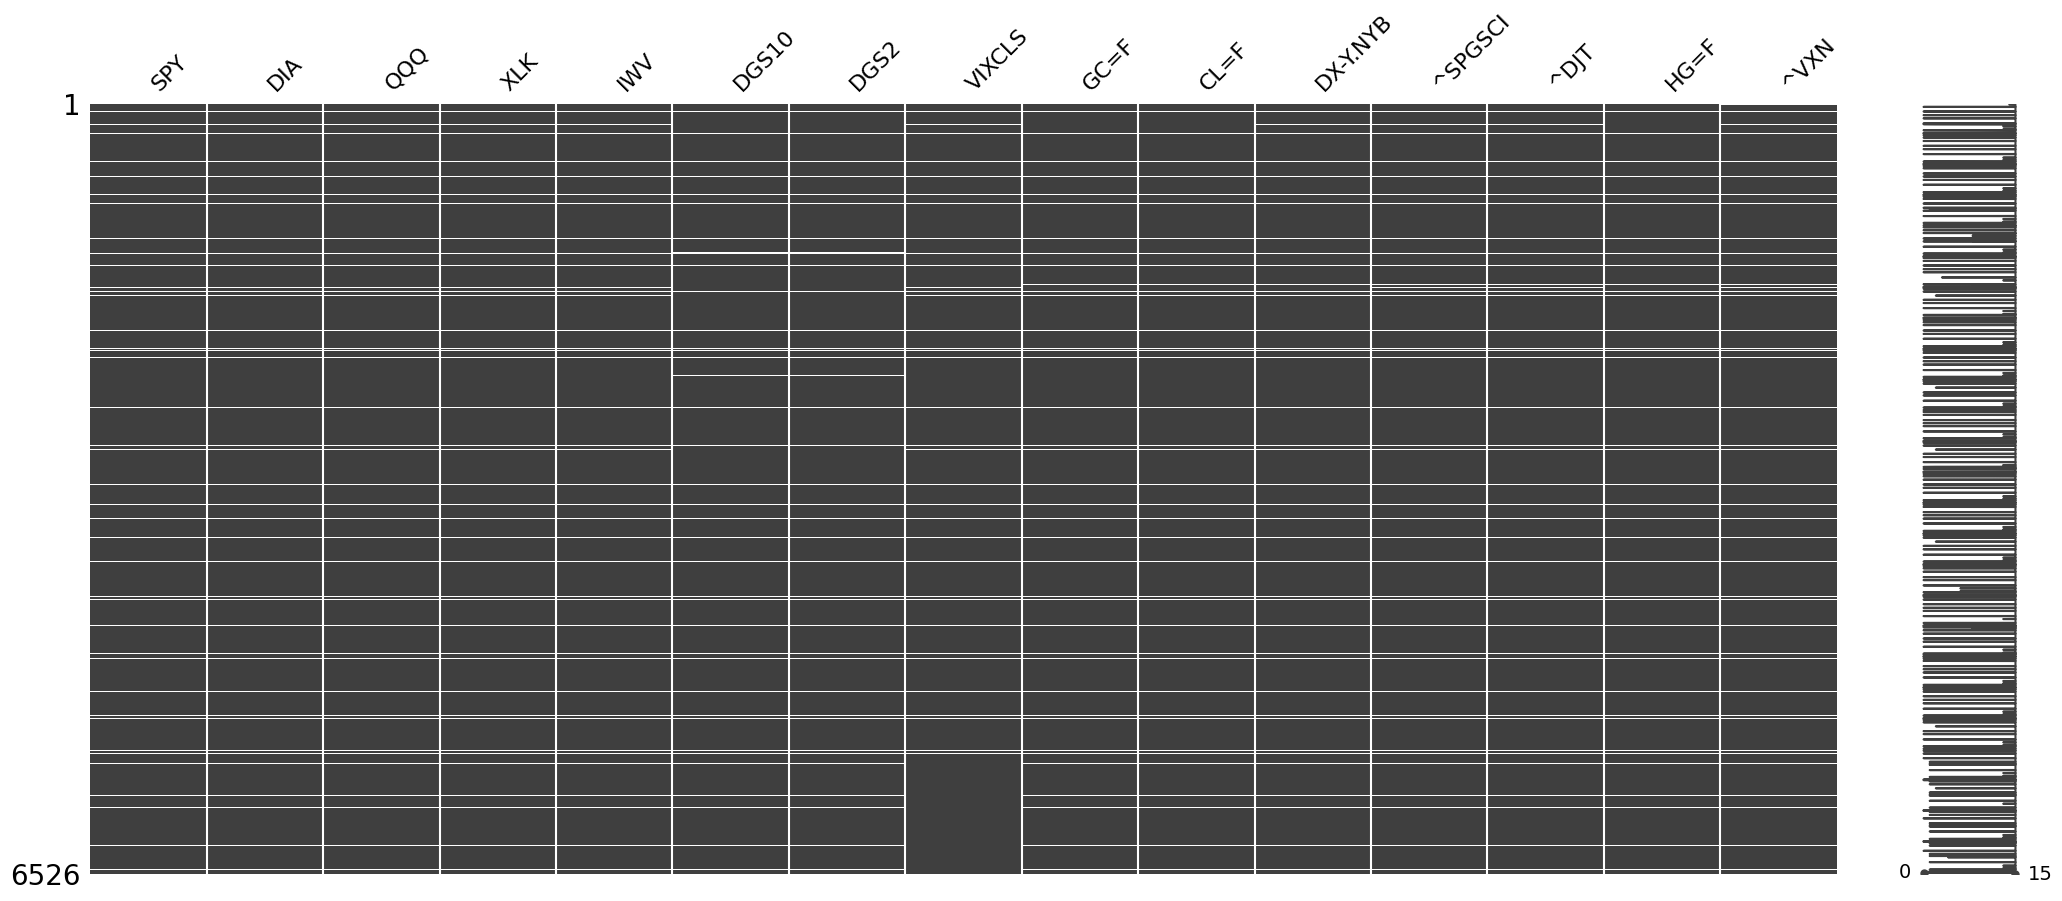

In [31]:
msno.matrix(df)
plt.show()

## 3.9 ANÁLISIS UNIVARIANTE

### 3.9.1 GRÁFICOS DE ETFS

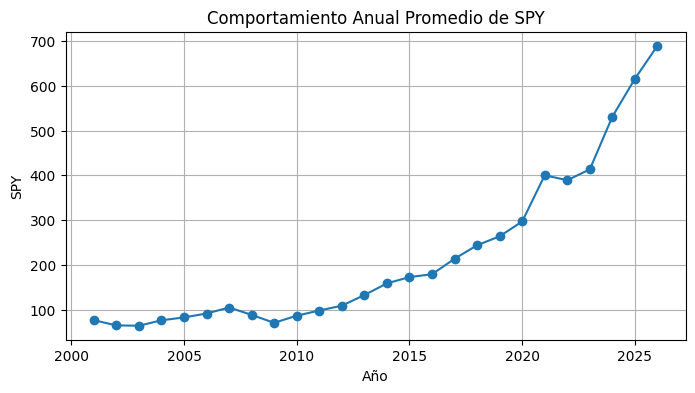

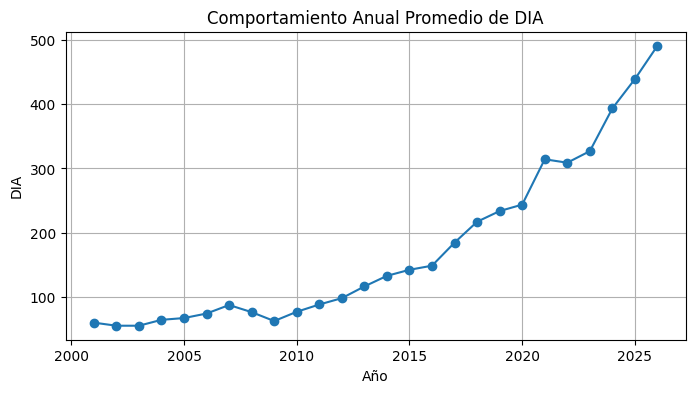

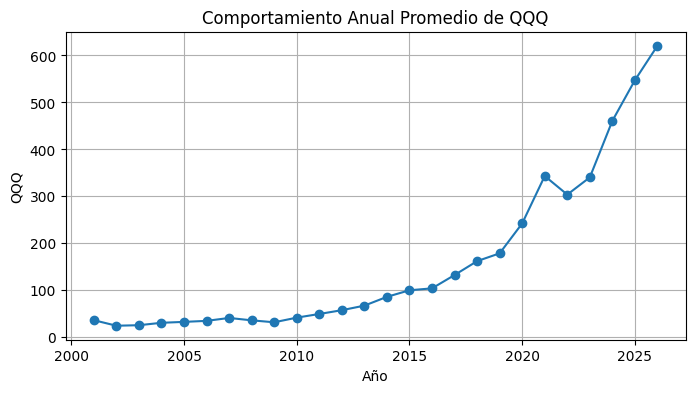

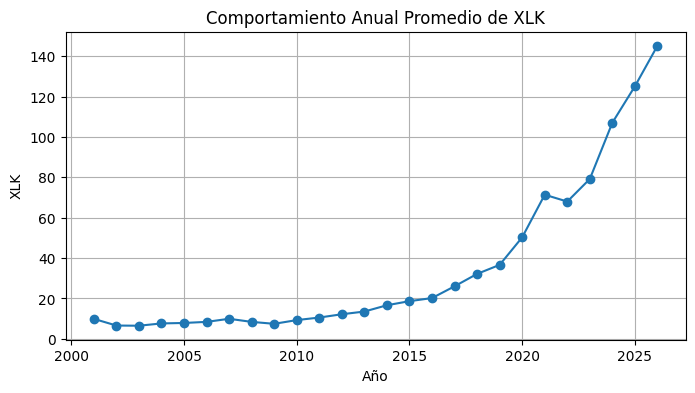

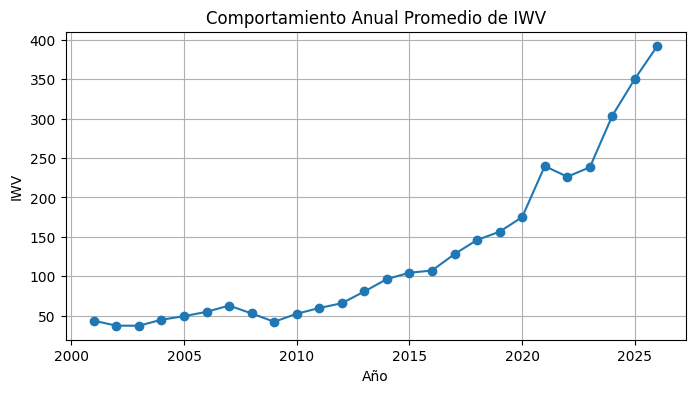

In [32]:
variables_etfs = ["SPY", "DIA", "QQQ", "XLK", "IWV"]
df_anual = df[variables_etfs].groupby(df.index.year).mean()
for var in variables_etfs:
        plt.figure(figsize=(8, 4))
        plt.plot(df_anual.index, df_anual[var], marker='o')
        plt.title(f'Comportamiento Anual Promedio de {var}')
        plt.xlabel('Año')
        plt.ylabel(var)
        plt.grid(True)
        plt.show()
        

### 3.9.2 GRÁFICOS DE VARIABLES EXOGENAS 

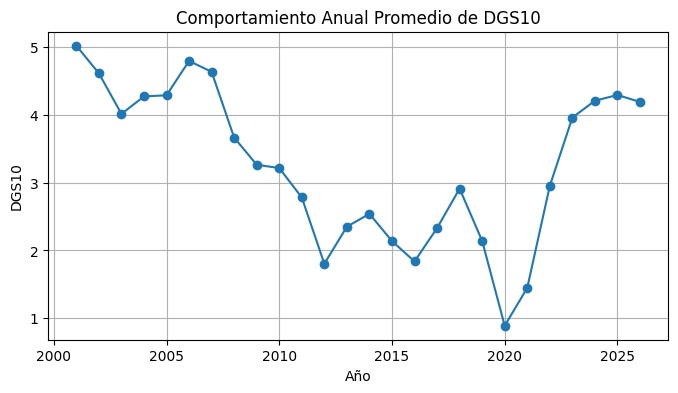

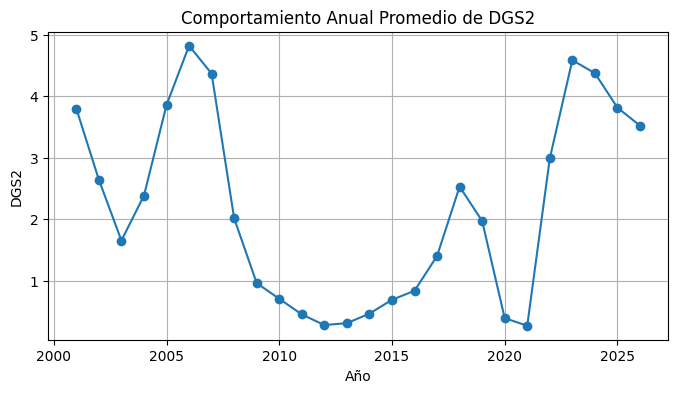

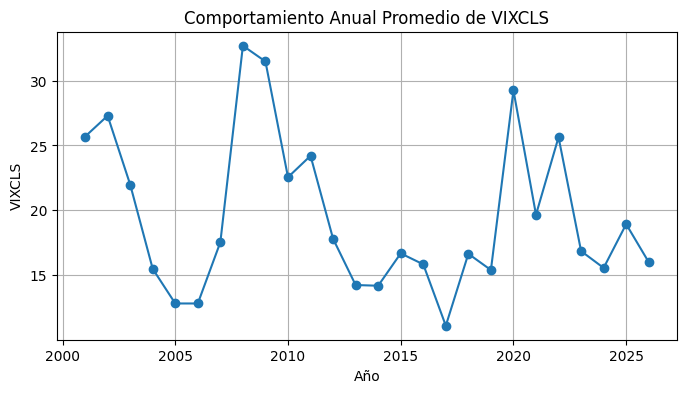

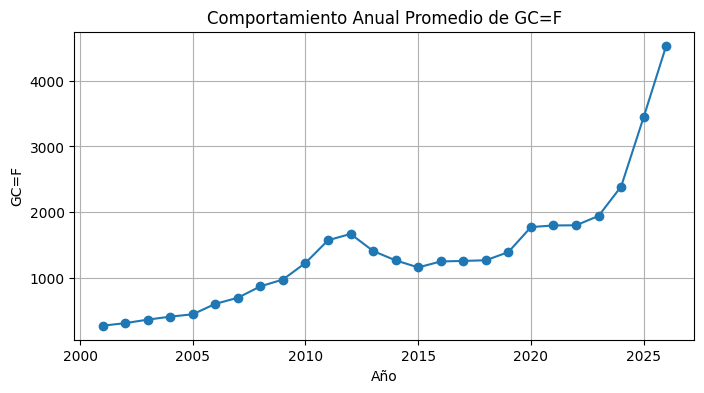

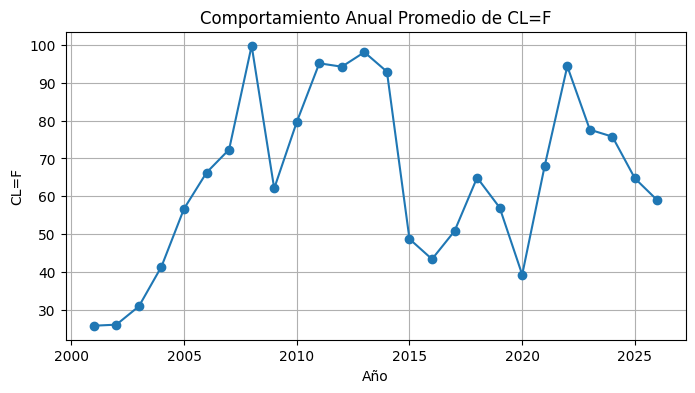

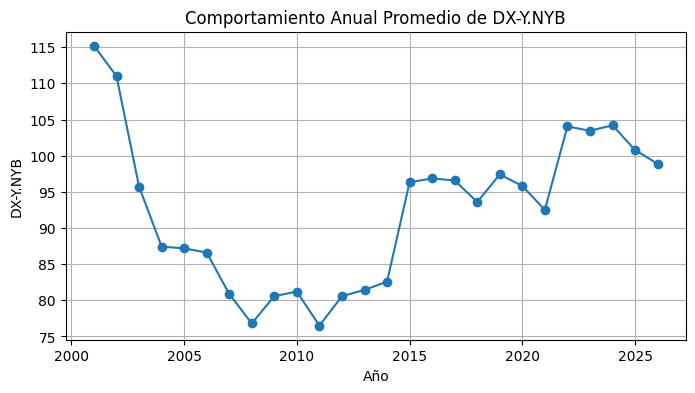

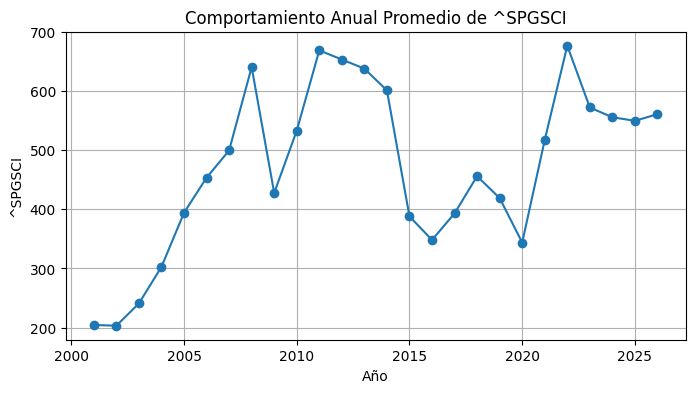

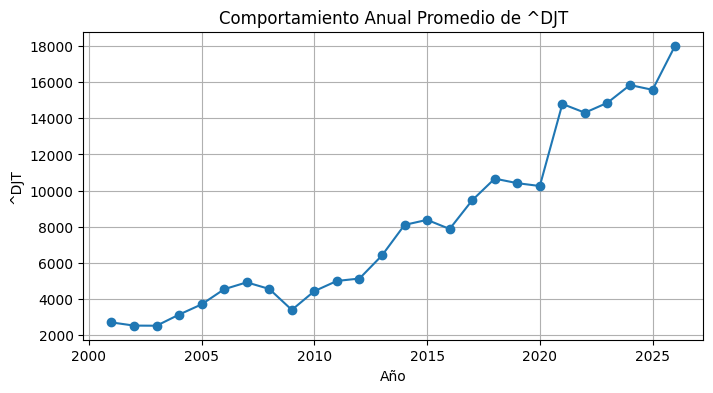

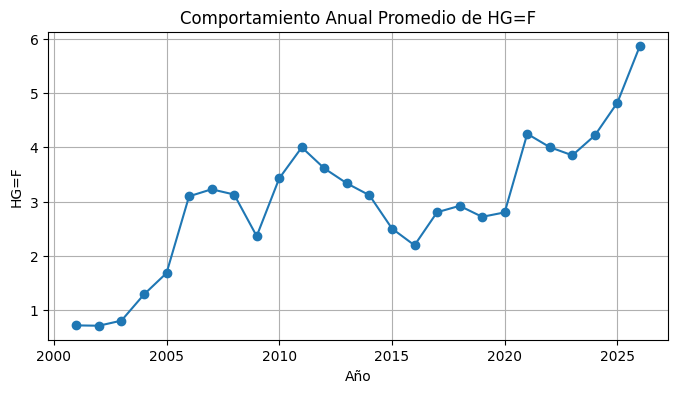

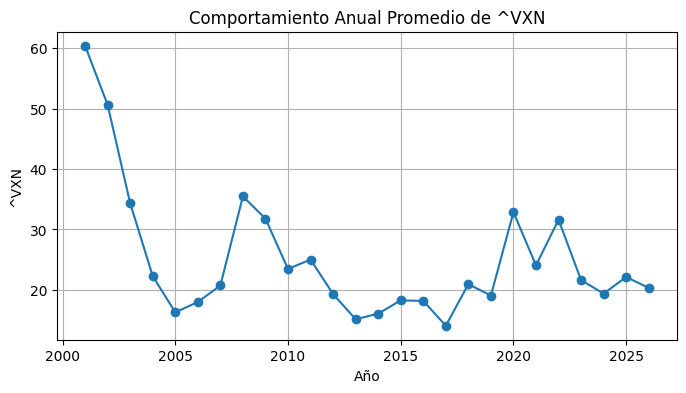

In [33]:
variables_exogenas = ['DGS10','DGS2','VIXCLS','GC=F','CL=F','DX-Y.NYB','^SPGSCI','^DJT','HG=F','^VXN']
df_anual = df[variables_exogenas].groupby(df.index.year).mean()
for var in variables_exogenas:
        plt.figure(figsize=(8, 4))
        plt.plot(df_anual.index, df_anual[var], marker='o')
        plt.title(f'Comportamiento Anual Promedio de {var}')
        plt.xlabel('Año')
        plt.ylabel(var)
        plt.grid(True)
        plt.show()

# 4. IMPUTACIÓN DE VALORES FALTANTES 

## 4.1 IMPUTACIÓN CON EL MÉTODO FORWARD FILL

Lo más recomendable en series temporales financieras es imputar con el valor anterior registrado, para así respetar la estructura secuencial de los datos, algo fundamental para evitar fuga de información y mantener coherencia en los datos.

El Método Forward fill (ffill): Rellena con el último valor conocido. Es simple y respeta la causalidad temporal.

In [34]:
df = df.ffill()

## 4.2 VERIFICACIÓN DE VALORES FALTANTES DESPUÉS DE IMPUTAR

In [35]:
df.isnull().sum()

SPY         0
DIA         0
QQQ         0
XLK         0
IWV         0
DGS10       0
DGS2        0
VIXCLS      0
GC=F        0
CL=F        0
DX-Y.NYB    0
^SPGSCI     0
^DJT        0
HG=F        0
^VXN        5
dtype: int64

## 4.3 IMPUTACIÓN DE LA COLUMNA ^VXN CON EL MÉTODO BACKWARD FILL

Como tenemos un caso especial con la columna ^VXN, donde justo los primeros 5 registros carecen de datos, entonces aplicaremos en esta columna el método bfill para rellenar esos valores faltantes con el siguiente valor disponible.

In [36]:
print(df['^VXN'].head(10))  # Verificación de ubicación y comportamiento de los datos faltantes en esta columna

2001-01-16          NaN
2001-01-17          NaN
2001-01-18          NaN
2001-01-19          NaN
2001-01-22          NaN
2001-01-23    58.570000
2001-01-24    60.660000
2001-01-25    63.480000
2001-01-26    62.459999
2001-01-29    62.400002
Name: ^VXN, dtype: float64


In [37]:
df['^VXN'] = df['^VXN'].ffill().bfill()

## 4.4 VERIFICACIÓN DE VALORES FALTANTES DESPUÉS DE IMPUTAR TODAS LAS COLUMNAS

In [38]:
df.isnull().sum()

SPY         0
DIA         0
QQQ         0
XLK         0
IWV         0
DGS10       0
DGS2        0
VIXCLS      0
GC=F        0
CL=F        0
DX-Y.NYB    0
^SPGSCI     0
^DJT        0
HG=F        0
^VXN        0
dtype: int64

## 4.5 VERIFICACIÓN DE OUTLIERS

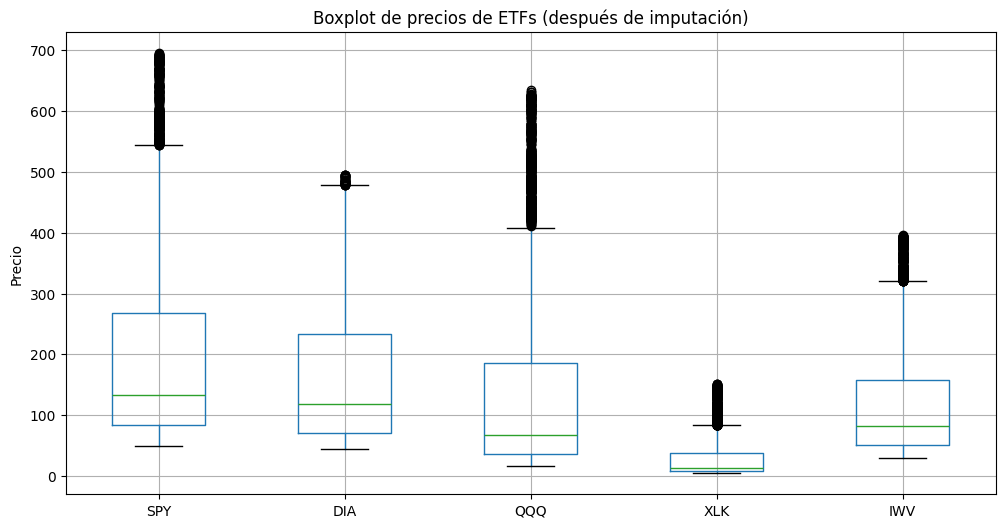

Resumen estadístico de los precios de los ETFs:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
SPY,6526.0,202.082362,156.188059,49.944584,55.789141,63.547192,84.211409,133.552498,268.400688,553.570679,667.051407,695.159973
DIA,6526.0,163.346168,114.815233,43.669231,48.613411,54.960109,70.705076,117.611485,233.622955,407.354889,463.827484,495.720490
QQQ,6526.0,141.649951,148.338011,16.943165,20.313224,25.201491,36.015013,67.647114,185.061501,478.714539,603.587357,634.951965
XLK,6526.0,31.033472,33.710718,4.313877,5.301377,6.194236,8.681624,13.558487,38.432462,110.237896,141.911030,151.834702
IWV,6526.0,118.873994,89.416435,29.074995,32.205897,37.266056,50.397907,81.259209,158.223705,315.262833,379.241028,395.600006


In [39]:
# --- ANÁLISIS DE OUTLIERS EN LOS PRECIOS DE LOS ETFs ---
import matplotlib.pyplot as plt

etf_cols = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']

plt.figure(figsize=(12, 6))
df[etf_cols].boxplot()
plt.title('Boxplot de precios de ETFs (después de imputación)')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

print('Resumen estadístico de los precios de los ETFs:')
display(df[etf_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T)

## 4.6 CREACIÓN DEL ARCHIVO CSV DEL DATASET GENERAL LIMPIO E IMPUTADO

In [40]:
# Guardar el DataSet en un archivo csv
output_dir = "DataSet_General"
os.makedirs(output_dir, exist_ok=True)

df.to_csv(os.path.join(output_dir, "DATASET_LIMPIO_E_IMPUTADO.csv"), index=True)

# 5. CREACIÓN DE LA FUNCIÓN MAKE SEQUENCES

In [43]:
def make_sequences(
    df,
    window=30,
    horizon=1,
    feature_cols=None,
    target_cols=None
):
    """- X: últimas `window` observaciones de TODAS las features
    - y: siguientes `horizon` días de los ETFs (aplanado)"""
    
    df = df.sort_values('Date').reset_index(drop=True) # Asegurar orden cronológico
    
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c != 'Date']
    if target_cols is None:
        target_cols=['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']
        
    "Convierte las columnas seleccionadas en matrices de números."  
    
    data_feat = df[feature_cols].values
    data_tgt  = df[target_cols].values
    
    "Preparar listas para guardar los resultados"
    
    X, y = [], []
    N = len(df)
    
    for i in range(N - window - horizon + 1):
        X.append(data_feat[i : i + window])
        y.append(data_tgt[i + window : i + window + horizon])
        
    X = np.array(X)
    y = np.array(y)
    
    """Convierte la matriz y en una sola fila por muestra,
    para que el modelo pueda predecir todos los valores futuros juntos."""
    
    num_targets = len(target_cols)
    y_flat = y.reshape(y.shape[0], horizon * num_targets)
    
    return X, y_flat, feature_cols, target_cols

In [44]:
if 'Date' not in df.columns:
    df = df.reset_index()
    if 'index' in df.columns:
        df = df.rename(columns={'index': 'Date'})

# 6. CREACIÓN DE SEMILLA, FEACTURES Y TARGETS

In [45]:
# AL INICIO DEL NOTEBOOK (antes de importar TensorFlow)
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Después de importar TensorFlow
import tensorflow as tf
import numpy as np
import random

# Semillas
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Configuración determinística (con manejo de errores si TF ya fue inicializado)
try:
    tf.config.experimental.enable_op_determinism()
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    print("✅ Configuración determinística aplicada correctamente")
except RuntimeError as e:
    print(f"⚠️  TensorFlow ya fue inicializado previamente. Configuración de paralelismo omitida.")
    print(f"   (La reproducibilidad puede verse afectada)")

# Definir columnas de features y targets
feature_cols = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV', 'DGS10', 'DGS2', 'VIXCLS', 'GC=F', 'CL=F', 'DX-Y.NYB', '^SPGSCI', '^DJT', 'HG=F', '^VXN']
target_cols  = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']



✅ Configuración determinística aplicada correctamente


# 7. APLICACIÓN DEL MÉTODO DIRECTO (PARA CADA ETF)

Antes el modelo intentaba predecir 25 valores simultáneamente (5 días × 5 ETFs), lo cual es muy difícil. Ahora Cada modelo solo predice 5 valores (1 día × 5 ETFs), lo cual es mucho más manejable.

## 7.1 MODELO DIRECTO CON DATOS DE 5 AÑOS

In [34]:
# ============================================
# MÉTODO DIRECTO CON DATOS RECIENTES (ROLL FORWARD)
# ============================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import os, pickle
import pandas as pd

# Configurar cuántos años recientes usar
años_recientes = 5

# Filtrar DataFrame para usar solo datos recientes
fecha_corte = pd.Timestamp.now() - pd.DateOffset(years=años_recientes)
df_reciente = df[df['Date'] >= fecha_corte].copy()

print("="*50)
print(f"ENTRENAMIENTO CON DATOS RECIENTES ({años_recientes} años)")
print("="*50)
print(f"Desde: {df_reciente['Date'].min()}")
print(f"Hasta: {df_reciente['Date'].max()}")
print(f"Total registros: {len(df_reciente)}")
print("="*50)

modelos_directos_recientes = []

for dia in range(1, 6):
    print(f"\n{'='*50}")
    print(f"Entrenando modelo para día {dia} (datos recientes)")
    print('='*50)

    WINDOW = 30
    HORIZON = dia

    # Secuencias con datos recientes
    X, y, _, _ = make_sequences(
        df_reciente,
        window=WINDOW,
        horizon=HORIZON,
        feature_cols=feature_cols,
        target_cols=target_cols
    )

    # Reacomoda y y toma solo el último paso (día objetivo)
    y = y.reshape(y.shape[0], HORIZON, 5)
    y = y[:, -1, :]

    # Split
    train_end = int(len(X) * 0.70)
    val_end = int(len(X) * 0.85)
    X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
    y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

    # Escalado
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_scaled   = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test_scaled  = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled   = scaler_y.transform(y_val)
    y_test_scaled  = scaler_y.transform(y_test)

    num_outputs = 5

    # Modelo
    modelo = Sequential([
        LSTM(128, input_shape=(WINDOW, X_train.shape[2])),
        Dense(128, activation='relu'),
        Dense(num_outputs)
    ])

    modelo.compile(optimizer='adam', loss='huber', metrics=['mape'])

    early_stop = EarlyStopping(
        monitor='val_mape',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_mape',
        factor=0.5,
        patience=7,
        verbose=1
    )

    modelo.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=200,
        batch_size=64,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Métricas en test
    y_pred_scaled = modelo.predict(X_test_scaled, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test_scaled)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape_val = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-7, None))) * 100

    print(f"\n📊 Métricas Modelo Día {dia} (Datos Recientes):")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape_val:.2f}%")

    modelos_directos_recientes.append({
        'dia': dia,
        'modelo': modelo,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'metricas': {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape_val}
    })

# Predicciones (última ventana del test)
X_ultimo = X_test_scaled[-1:, :, :]

predicciones_recientes = []
for m in modelos_directos_recientes:
    pred_scaled = m['modelo'].predict(X_ultimo, verbose=0)
    pred = m['scaler_y'].inverse_transform(pred_scaled)
    predicciones_recientes.append(pred[0])

predicciones_recientes = np.array(predicciones_recientes)

etf_names = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']
print("\n" + "="*50)
print("PREDICCIONES MÉTODO DIRECTO (Datos Recientes - 5 días)")
print("="*50)
for i, etf in enumerate(etf_names):
    print(f"\n{etf}:")
    for dia in range(5):
        print(f"  Día {dia+1}: ${predicciones_recientes[dia, i]:.2f}")

# Resumen métricas
print("\n" + "="*50)
print("RESUMEN DE MÉTRICAS POR DÍA (Datos Recientes)")
print("="*50)
df_metricas_recientes = pd.DataFrame([m['metricas'] for m in modelos_directos_recientes])
df_metricas_recientes.insert(0, 'Día', range(1, 6))
display(df_metricas_recientes)

# Guardado en carpeta separada
carpeta_recientes = "modelos_directos_recientes"
os.makedirs(carpeta_recientes, exist_ok=True)

for m in modelos_directos_recientes:
    dia = m['dia']
    m['modelo'].save(f"{carpeta_recientes}/modelo_dia{dia}.h5")
    with open(f"{carpeta_recientes}/scaler_X_dia{dia}.pkl", 'wb') as f:
        pickle.dump(m['scaler_X'], f)
    with open(f"{carpeta_recientes}/scaler_y_dia{dia}.pkl", 'wb') as f:
        pickle.dump(m['scaler_y'], f)
    print(f"✓ Modelo día {dia} (reciente) y scalers guardados")

# Guardar metadata
metadata = {
    'años_recientes': años_recientes,
    'fecha_desde': str(df_reciente['Date'].min()),
    'fecha_hasta': str(df_reciente['Date'].max()),
    'total_registros': len(df_reciente),
    'window': WINDOW,
    'feature_cols': feature_cols,
    'target_cols': target_cols
}

with open(f"{carpeta_recientes}/metadata.pkl", 'wb') as f:
    pickle.dump(metadata, f)

print("\n" + "="*50)
print(f"✓ TODOS LOS ARCHIVOS GUARDADOS EN: {carpeta_recientes}/")
print("✓ Metadata guardada con información del período usado")
print("="*50)

ENTRENAMIENTO CON DATOS RECIENTES (5 años)
Desde: 2021-02-03 00:00:00
Hasta: 2026-01-20 00:00:00
Total registros: 1295

Entrenando modelo para día 1 (datos recientes)


c:\Users\monit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0267 - mape: 167163.2500 - val_loss: 0.0404 - val_mape: 25.4685 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0024 - mape: 56873.4688 - val_loss: 0.0063 - val_mape: 9.3388 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0014 - mape: 107534.1016 - val_loss: 0.0043 - val_mape: 7.6339 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 9.8781e-04 - mape: 92820.3750 - val_loss: 0.0038 - val_mape: 7.1569 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 8.3874e-04 - mape: 94447.7656 - val_loss: 0.0036 - val_mape: 6.8674 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 7.5915e-04 - mape: 91282.3594 - val_loss: 0.0033 - val_mape: 6.5968 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 6.9411e-04 - mape: 89643.4453 - va

c:\Users\monit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0227 - mape: 151571.4375 - val_loss: 0.0194 - val_mape: 16.7276 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0027 - mape: 68483.3125 - val_loss: 0.0112 - val_mape: 11.6793 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0014 - mape: 85781.0703 - val_loss: 0.0046 - val_mape: 7.7678 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0010 - mape: 78194.2188 - val_loss: 0.0051 - val_mape: 8.2061 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 9.3025e-04 - mape: 93586.2734 - val_loss: 0.0043 - val_mape: 7.4335 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 8.4399e-04 - mape: 83587.9844 - val_loss: 0.0040 - val_mape: 7.1690 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 7.8581e-04 - mape: 83931.3359 - val_loss: 0.0037 - v

c:\Users\monit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0266 - mape: 65467.2305 - val_loss: 0.0193 - val_mape: 15.6211 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0027 - mape: 127243.2734 - val_loss: 0.0086 - val_mape: 9.9840 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0016 - mape: 82221.0078 - val_loss: 0.0076 - val_mape: 9.6891 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0013 - mape: 108816.5312 - val_loss: 0.0057 - val_mape: 8.4019 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0012 - mape: 102842.2109 - val_loss: 0.0062 - val_mape: 8.8972 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0011 - mape: 106233.8438 - val_loss: 0.0055 - val_mape: 8.3434 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0010 - mape: 105777.6641 - val_loss: 0.0052 - val_mape: 8

c:\Users\monit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 0.0221 - mape: 348035.1562 - val_loss: 0.0373 - val_mape: 20.5788 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0028 - mape: 55547.0156 - val_loss: 0.0070 - val_mape: 9.6725 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0016 - mape: 91224.6484 - val_loss: 0.0060 - val_mape: 8.6103 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0013 - mape: 95671.6094 - val_loss: 0.0063 - val_mape: 8.8884 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0011 - mape: 108983.5078 - val_loss: 0.0059 - val_mape: 8.6131 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0011 - mape: 115322.3359 - val_loss: 0.0056 - val_mape: 8.4131 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0010 - mape: 113341.7969 - val_loss: 0.0055 - val_mape: 8

c:\Users\monit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0237 - mape: 249294.9531 - val_loss: 0.0308 - val_mape: 20.0965 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0029 - mape: 69898.3203 - val_loss: 0.0096 - val_mape: 10.7111 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0019 - mape: 97270.9062 - val_loss: 0.0068 - val_mape: 8.9686 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0016 - mape: 111080.4453 - val_loss: 0.0049 - val_mape: 7.8032 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0014 - mape: 108143.7969 - val_loss: 0.0044 - val_mape: 7.3811 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0013 - mape: 110653.9609 - val_loss: 0.0041 - val_mape: 7.1830 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0012 - mape: 109375.3594 - val_loss: 0.0040 - val_mape:

,Día,MAE,RMSE,R2,MAPE
0,1,21.332525,26.222918,0.247708,4.960421
1,2,17.840801,22.464170,0.422988,4.041962
2,3,20.775942,26.932223,0.185762,4.806209
3,4,21.028188,25.889299,0.212257,4.910871
4,5,20.236612,25.715471,0.305712,4.670438


✓ Modelo día 1 (reciente) y scalers guardados
✓ Modelo día 2 (reciente) y scalers guardados
✓ Modelo día 3 (reciente) y scalers guardados
✓ Modelo día 4 (reciente) y scalers guardados
✓ Modelo día 5 (reciente) y scalers guardados

✓ TODOS LOS ARCHIVOS GUARDADOS EN: modelos_directos_recientes/
✓ Metadata guardada con información del período usado


## 7.2 MÉTRICAS DETALLADAS EN TRAIN, VALIDACIÓN Y TEST PARA LOS 5 DÍAS

In [35]:
# ============================================
# CÁLCULO DE MÉTRICAS EN TRAIN, VALIDACIÓN Y TEST
# ============================================

# Función para calcular MAPE
def calcular_mape(y_true, y_pred):
    """Calcula MAPE evitando división por cero"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Función para calcular todas las métricas
def calcular_metricas(y_true, y_pred, conjunto):
    """Calcula MAE, RMSE, R² y MAPE"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape_val = calcular_mape(y_true, y_pred)
    
    return {
        'Conjunto': conjunto,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape_val
    }

# Diccionario para almacenar todas las métricas por día
metricas_completas = {dia: [] for dia in range(1, 6)}

# Recorrer cada modelo entrenado
for m in modelos_directos_recientes:
    dia = m['dia']
    modelo = m['modelo']
    scaler_X = m['scaler_X']
    scaler_y = m['scaler_y']
    
    print(f"\n{'='*70}")
    print(f"CALCULANDO MÉTRICAS PARA MODELO DÍA {dia}")
    print('='*70)
    
    # Necesitamos reconstruir los datos para este día específico
    WINDOW = 30
    HORIZON = dia
    
    X, y, _, _ = make_sequences(
        df_reciente,
        window=WINDOW,
        horizon=HORIZON,
        feature_cols=feature_cols,
        target_cols=target_cols
    )
    
    y = y.reshape(y.shape[0], HORIZON, 5)
    y = y[:, -1, :]
    
    # Split (mismo que en entrenamiento)
    train_end = int(len(X) * 0.70)
    val_end = int(len(X) * 0.85)
    X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
    y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]
    
    # Escalado (mismo que en entrenamiento)
    X_train_scaled = scaler_X.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    
    y_train_scaled = scaler_y.transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)
    
    # 1. MÉTRICAS EN TRAIN
    y_train_pred_scaled = modelo.predict(X_train_scaled, verbose=0)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_train_true = scaler_y.inverse_transform(y_train_scaled)
    metricas_train = calcular_metricas(y_train_true, y_train_pred, 'Train')
    metricas_completas[dia].append(metricas_train)
    
    # 2. MÉTRICAS EN VALIDACIÓN
    y_val_pred_scaled = modelo.predict(X_val_scaled, verbose=0)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_val_true = scaler_y.inverse_transform(y_val_scaled)
    metricas_val = calcular_metricas(y_val_true, y_val_pred, 'Validación')
    metricas_completas[dia].append(metricas_val)
    
    # 3. MÉTRICAS EN TEST
    y_test_pred_scaled = modelo.predict(X_test_scaled, verbose=0)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_true = scaler_y.inverse_transform(y_test_scaled)
    metricas_test = calcular_metricas(y_test_true, y_test_pred, 'Test')
    metricas_completas[dia].append(metricas_test)
    
    # Mostrar tabla para este día
    df_metricas_dia = pd.DataFrame(metricas_completas[dia])
    print(f"\n📊 MÉTRICAS MODELO DÍA {dia}:")
    display(df_metricas_dia)

# ============================================
# RESUMEN CONSOLIDADO PARA LOS 5 DÍAS
# ============================================

print("\n" + "="*70)
print("RESUMEN CONSOLIDADO DE MÉTRICAS PARA LOS 5 DÍAS")
print("="*70)

for dia in range(1, 6):
    print(f"\n{'─'*70}")
    print(f"DÍA {dia}")
    print('─'*70)
    df_metricas_dia = pd.DataFrame(metricas_completas[dia])
    display(df_metricas_dia)

# ============================================
# COMPARACIÓN VISUAL: TEST vs TRAIN/VAL
# ============================================

print("\n" + "="*70)
print("ANÁLISIS DE SOBREAJUSTE (TRAIN vs VAL vs TEST)")
print("="*70)

# Crear DataFrame comparativo
comparacion = []
for dia in range(1, 6):
    metricas_dia = metricas_completas[dia]
    train_metrics = metricas_dia[0]
    val_metrics = metricas_dia[1]
    test_metrics = metricas_dia[2]
    
    comparacion.append({
        'Día': dia,
        'MAE_Train': train_metrics['MAE'],
        'MAE_Val': val_metrics['MAE'],
        'MAE_Test': test_metrics['MAE'],
        'RMSE_Train': train_metrics['RMSE'],
        'RMSE_Val': val_metrics['RMSE'],
        'RMSE_Test': test_metrics['RMSE'],
        'R²_Train': train_metrics['R²'],
        'R²_Val': val_metrics['R²'],
        'R²_Test': test_metrics['R²'],
        'MAPE_Train': train_metrics['MAPE'],
        'MAPE_Val': val_metrics['MAPE'],
        'MAPE_Test': test_metrics['MAPE']
    })

df_comparacion = pd.DataFrame(comparacion)
display(df_comparacion)

# Diagnóstico de sobreajuste
print("\n" + "="*70)
print("DIAGNÓSTICO DE SOBREAJUSTE")
print("="*70)

for dia in range(1, 6):
    row = df_comparacion[df_comparacion['Día'] == dia].iloc[0]
    
    # Diferencia entre Train y Test
    diff_mae = ((row['MAE_Test'] - row['MAE_Train']) / row['MAE_Train']) * 100
    diff_rmse = ((row['RMSE_Test'] - row['RMSE_Train']) / row['RMSE_Train']) * 100
    
    print(f"\nDía {dia}:")
    print(f"  MAE:  Train={row['MAE_Train']:.4f}, Val={row['MAE_Val']:.4f}, Test={row['MAE_Test']:.4f} | Δ Train-Test: {diff_mae:+.2f}%")
    print(f"  RMSE: Train={row['RMSE_Train']:.4f}, Val={row['RMSE_Val']:.4f}, Test={row['RMSE_Test']:.4f} | Δ Train-Test: {diff_rmse:+.2f}%")
    print(f"  R²:   Train={row['R²_Train']:.4f}, Val={row['R²_Val']:.4f}, Test={row['R²_Test']:.4f}")
    print(f"  MAPE: Train={row['MAPE_Train']:.2f}%, Val={row['MAPE_Val']:.2f}%, Test={row['MAPE_Test']:.2f}%")
    
    # Interpretación
    if abs(diff_mae) < 10:
        print(f"  ✅ Buen balance entre Train y Test")
    elif diff_mae > 10:
        print(f"  ⚠️  Posible subajuste (Test peor que Train)")
    else:
        print(f"  ⚠️  Posible sobreajuste (Test mejor que Train, inusual)")

print("\n" + "="*70)


CALCULANDO MÉTRICAS PARA MODELO DÍA 1

📊 MÉTRICAS MODELO DÍA 1:


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,3.114581,4.331617,0.985256,1.183505
1,Validación,8.524583,10.979904,0.673562,2.291380
2,Test,21.332525,26.222918,0.247708,4.960421



CALCULANDO MÉTRICAS PARA MODELO DÍA 2

📊 MÉTRICAS MODELO DÍA 2:


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,4.051072,5.634436,0.975391,1.556478
1,Validación,7.620788,10.139886,0.630642,2.300604
2,Test,17.840801,22.464170,0.422988,4.041962



CALCULANDO MÉTRICAS PARA MODELO DÍA 3

📊 MÉTRICAS MODELO DÍA 3:


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,4.316617,6.021065,0.971802,1.651912
1,Validación,9.427997,12.659016,0.577145,2.526332
2,Test,20.775942,26.932223,0.185762,4.806209



CALCULANDO MÉTRICAS PARA MODELO DÍA 4

📊 MÉTRICAS MODELO DÍA 4:


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,4.911527,6.748431,0.964981,1.842585
1,Validación,11.559029,14.695074,0.292602,3.169727
2,Test,21.028188,25.889299,0.212257,4.910871



CALCULANDO MÉTRICAS PARA MODELO DÍA 5

📊 MÉTRICAS MODELO DÍA 5:


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,5.682820,7.854450,0.952003,2.162980
1,Validación,9.799907,13.297115,0.400335,2.899129
2,Test,20.236612,25.715471,0.305712,4.670438



RESUMEN CONSOLIDADO DE MÉTRICAS PARA LOS 5 DÍAS

──────────────────────────────────────────────────────────────────────
DÍA 1
──────────────────────────────────────────────────────────────────────


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,3.114581,4.331617,0.985256,1.183505
1,Validación,8.524583,10.979904,0.673562,2.291380
2,Test,21.332525,26.222918,0.247708,4.960421



──────────────────────────────────────────────────────────────────────
DÍA 2
──────────────────────────────────────────────────────────────────────


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,4.051072,5.634436,0.975391,1.556478
1,Validación,7.620788,10.139886,0.630642,2.300604
2,Test,17.840801,22.464170,0.422988,4.041962



──────────────────────────────────────────────────────────────────────
DÍA 3
──────────────────────────────────────────────────────────────────────


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,4.316617,6.021065,0.971802,1.651912
1,Validación,9.427997,12.659016,0.577145,2.526332
2,Test,20.775942,26.932223,0.185762,4.806209



──────────────────────────────────────────────────────────────────────
DÍA 4
──────────────────────────────────────────────────────────────────────


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,4.911527,6.748431,0.964981,1.842585
1,Validación,11.559029,14.695074,0.292602,3.169727
2,Test,21.028188,25.889299,0.212257,4.910871



──────────────────────────────────────────────────────────────────────
DÍA 5
──────────────────────────────────────────────────────────────────────


,Conjunto,MAE,RMSE,R²,MAPE
0,Train,5.682820,7.854450,0.952003,2.162980
1,Validación,9.799907,13.297115,0.400335,2.899129
2,Test,20.236612,25.715471,0.305712,4.670438



ANÁLISIS DE SOBREAJUSTE (TRAIN vs VAL vs TEST)


,Día,MAE_Train,MAE_Val,MAE_Test,RMSE_Train,RMSE_Val,RMSE_Test,R²_Train,R²_Val,R²_Test,MAPE_Train,MAPE_Val,MAPE_Test
0,1,3.114581,8.524583,21.332525,4.331617,10.979904,26.222918,0.985256,0.673562,0.247708,1.183505,2.291380,4.960421
1,2,4.051072,7.620788,17.840801,5.634436,10.139886,22.464170,0.975391,0.630642,0.422988,1.556478,2.300604,4.041962
2,3,4.316617,9.427997,20.775942,6.021065,12.659016,26.932223,0.971802,0.577145,0.185762,1.651912,2.526332,4.806209
3,4,4.911527,11.559029,21.028188,6.748431,14.695074,25.889299,0.964981,0.292602,0.212257,1.842585,3.169727,4.910871
4,5,5.682820,9.799907,20.236612,7.854450,13.297115,25.715471,0.952003,0.400335,0.305712,2.162980,2.899129,4.670438



DIAGNÓSTICO DE SOBREAJUSTE

Día 1:
  MAE:  Train=3.1146, Val=8.5246, Test=21.3325 | Δ Train-Test: +584.92%
  RMSE: Train=4.3316, Val=10.9799, Test=26.2229 | Δ Train-Test: +505.38%
  R²:   Train=0.9853, Val=0.6736, Test=0.2477
  MAPE: Train=1.18%, Val=2.29%, Test=4.96%
  ⚠️  Posible subajuste (Test peor que Train)

Día 2:
  MAE:  Train=4.0511, Val=7.6208, Test=17.8408 | Δ Train-Test: +340.40%
  RMSE: Train=5.6344, Val=10.1399, Test=22.4642 | Δ Train-Test: +298.69%
  R²:   Train=0.9754, Val=0.6306, Test=0.4230
  MAPE: Train=1.56%, Val=2.30%, Test=4.04%
  ⚠️  Posible subajuste (Test peor que Train)

Día 3:
  MAE:  Train=4.3166, Val=9.4280, Test=20.7759 | Δ Train-Test: +381.30%
  RMSE: Train=6.0211, Val=12.6590, Test=26.9322 | Δ Train-Test: +347.30%
  R²:   Train=0.9718, Val=0.5771, Test=0.1858
  MAPE: Train=1.65%, Val=2.53%, Test=4.81%
  ⚠️  Posible subajuste (Test peor que Train)

Día 4:
  MAE:  Train=4.9115, Val=11.5590, Test=21.0282 | Δ Train-Test: +328.14%
  RMSE: Train=6.7484, Val=1

# 8. CARGA DE MODELOS GUARDADOS

In [56]:
# ============================================
# CARGA ALTERNATIVA SIMPLIFICADA: load_weights()
# ============================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import pickle
import os

print("="*70)
print("CARGANDO MODELOS - ESTRATEGIA SIMPLIFICADA")
print("="*70)

carpeta = "modelos_directos_recientes"
WINDOW = 30
num_features = 15
num_outputs = 5

if not os.path.exists(carpeta):
    print(f"❌ Error: No existe la carpeta '{carpeta}'")
else:
    modelos_guardados = []
    
    for dia in range(1, 6):
        try:
            # 1. RECONSTRUIR exactamente igual que el original
            modelo = Sequential([
                Input(shape=(WINDOW, num_features)),
                LSTM(128),
                Dense(128, activation='relu'),
                Dense(num_outputs)
            ])
            
            modelo.compile(optimizer='adam', loss='huber')
            
            # 2. CARGAR PESOS directamente (sin deserializar configuración)
            modelo.load_weights(f"{carpeta}/modelo_dia{dia}.h5")
            
            # 3. CARGAR SCALERS
            with open(f"{carpeta}/scaler_X_dia{dia}.pkl", 'rb') as f:
                scaler_X = pickle.load(f)
            
            with open(f"{carpeta}/scaler_y_dia{dia}.pkl", 'rb') as f:
                scaler_y = pickle.load(f)
            
            modelos_guardados.append({
                'dia': dia,
                'modelo': modelo,
                'scaler_X': scaler_X,
                'scaler_y': scaler_y
            })
            
            print(f"✓ Día {dia}: Cargado exitosamente")
            
        except Exception as e:
            print(f"❌ Día {dia}: {str(e)[:100]}")
    
    print("\n" + "="*70)
    print(f"✅ Total de modelos cargados: {len(modelos_guardados)}/5")
    print("="*70)
    
    if len(modelos_guardados) == 5:
        print("\n✓ LISTO PARA WALK-FORWARD")
    else:
        print(f"\n⚠️  Revisar los {5 - len(modelos_guardados)} modelos")


CARGANDO MODELOS - ESTRATEGIA SIMPLIFICADA
✓ Día 1: Cargado exitosamente
✓ Día 2: Cargado exitosamente
✓ Día 3: Cargado exitosamente
✓ Día 4: Cargado exitosamente
✓ Día 5: Cargado exitosamente

✅ Total de modelos cargados: 5/5

✓ LISTO PARA WALK-FORWARD


c:\Users\ingen\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# 9 WALK-FORWARD CON DATOS DE TEST ÚNICAMENTE

## 9.1 APLICACIÓN DEL WALK-FORWARD

In [57]:
from tensorflow.keras.models import clone_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def walk_forward_fine_tuning(
    df,
    modelos_preentrenados,
    horizon=1,
    window=30,
    years=5,
    mode='expanding',
    fine_tune_epochs=3,
    batch_size=64,
    max_steps=50,
    verbose=0,
    feature_cols=None,      # ← AGREGAR
    target_cols=None        # ← AGREGAR
):
    """
    Walk-forward que REUTILIZA modelos pre-entrenados y los adapta (fine-tune) 
    en cada paso con datos nuevos. Mucho más eficiente que reentrenar desde cero.
    """
    
    # Asignar valores por defecto si no se proporcionan
    if feature_cols is None:
        feature_cols = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV', 'DGS10', 'DGS2', 
                       'VIXCLS', 'GC=F', 'CL=F', 'DX-Y.NYB', '^SPGSCI', '^DJT', 'HG=F', '^VXN']
    if target_cols is None:
        target_cols = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']
    
    # Filtrar datos recientes
    fecha_corte = pd.Timestamp.now() - pd.DateOffset(years=years)
    df_reciente = df[df['Date'] >= fecha_corte].copy()

    X, y, _, _ = make_sequences(
        df_reciente,
        window=window,
        horizon=horizon,
        feature_cols=feature_cols,
        target_cols=target_cols
    )

    y = y.reshape(y.shape[0], horizon, len(target_cols))
    y = y[:, -1, :]  # solo el día objetivo

    train_end = int(len(X) * 0.70)
    val_end = int(len(X) * 0.85)
    start_test = val_end

    preds, actuals = [], []

    pasos = len(X) - start_test
    if max_steps is not None:
        pasos = min(pasos, max_steps)

    # Obtener modelo pre-entrenado base
    modelo_base = modelos_preentrenados[horizon - 1]['modelo'] if horizon <= len(modelos_preentrenados) else modelos_preentrenados[0]['modelo']
    
    print(f"✓ Usando modelo pre-entrenado (Día {horizon}) como base para fine-tuning")

    for i in range(pasos):
        idx = start_test + i

        if mode == 'expanding':
            X_train_wf = X[:idx]
            y_train_wf = y[:idx]
        elif mode == 'rolling':
            train_size = train_end
            start_idx = max(0, idx - train_size)
            X_train_wf = X[start_idx:idx]
            y_train_wf = y[start_idx:idx]
        else:
            raise ValueError("mode debe ser 'expanding' o 'rolling'")

        # Escalado dinámico
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(
            X_train_wf.reshape(-1, X_train_wf.shape[-1])
        ).reshape(X_train_wf.shape)
        y_train_scaled = scaler_y.fit_transform(y_train_wf)

        # CLONAR el modelo pre-entrenado
        modelo_wf = clone_model(modelo_base)
        modelo_wf.set_weights(modelo_base.get_weights())
        modelo_wf.compile(optimizer='adam', loss='huber')

        # FINE-TUNING ligero
        modelo_wf.fit(
            X_train_scaled,
            y_train_scaled,
            epochs=fine_tune_epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)]
        )

        # Predicción 1‑paso adelante
        X_test_sample = X[idx:idx+1]
        X_test_scaled = scaler_X.transform(
            X_test_sample.reshape(-1, X_test_sample.shape[-1])
        ).reshape(X_test_sample.shape)

        # ✅ USAR X_test_scaled (escalado) en lugar de X_test_sample
        y_pred_scaled = modelo_wf.predict(X_test_scaled, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)

        preds.append(y_pred[0])
        actuals.append(y[idx])

        if (i + 1) % 10 == 0:
            print(f"  Paso {i+1}/{pasos} completado (fine-tune)")

    return np.array(preds), np.array(actuals)


# ============================================
# EJECUTAR WALK-FORWARD
# ============================================

print("="*70)
print("WALK-FORWARD CON FINE-TUNING")
print("="*70)

preds_wf_ft, actuals_wf_ft = walk_forward_fine_tuning(
    df,
    modelos_preentrenados=modelos_guardados,
    horizon=1,
    window=30,
    years=5,
    mode='expanding',
    fine_tune_epochs=3,
    max_steps=50,
    verbose=0,
    feature_cols=feature_cols,  # ← PASAR explícitamente
    target_cols=target_cols     # ← PASAR explícitamente
)

# Calcular métricas
mae_wf_ft = np.mean(np.abs(actuals_wf_ft - preds_wf_ft))
rmse_wf_ft = np.sqrt(np.mean((actuals_wf_ft - preds_wf_ft)**2))
mape_wf_ft = np.mean(np.abs((actuals_wf_ft - preds_wf_ft) / np.clip(np.abs(actuals_wf_ft), 1e-7, None))) * 100

print(f"\n📊 RESULTADOS WALK-FORWARD (Fine-tuning):") 
print(f"  MAE:  {mae_wf_ft:.4f}")
print(f"  RMSE: {rmse_wf_ft:.4f}")
print(f"  MAPE: {mape_wf_ft:.2f}%")
print(f"  Pasos evaluados: {len(preds_wf_ft)}")
print(f"\n✓ Ventaja: Usa modelos pre-entrenados (MÁS RÁPIDO que reentrenar)")

# ============================================
# GUARDAR RESULTADOS DEL WALK-FORWARD
# ============================================

import pickle

resultados_wf = {
    'preds': preds_wf_ft,
    'actuals': actuals_wf_ft,
    'metricas': {
        'MAE': mae_wf_ft,
        'RMSE': rmse_wf_ft,
        'MAPE': mape_wf_ft
    }
}

with open('walk_forward_dia1.pkl', 'wb') as f:
    pickle.dump(resultados_wf, f)

print("\n✓ Resultados guardados en: walk_forward_dia1.pkl")

WALK-FORWARD CON FINE-TUNING
✓ Usando modelo pre-entrenado (Día 1) como base para fine-tuning
  Paso 10/50 completado (fine-tune)
  Paso 20/50 completado (fine-tune)
  Paso 30/50 completado (fine-tune)
  Paso 40/50 completado (fine-tune)
  Paso 50/50 completado (fine-tune)

📊 RESULTADOS WALK-FORWARD (Fine-tuning):
  MAE:  5.6696
  RMSE: 7.4193
  MAPE: 1.62%
  Pasos evaluados: 50

✓ Ventaja: Usa modelos pre-entrenados (MÁS RÁPIDO que reentrenar)

✓ Resultados guardados en: walk_forward_dia1.pkl


In [ ]:
# Guardar datos del Walk Forward Testing para usar en page_3
datos_wf = {
    'actuals_wf_ft': actuals_wf_ft,
    'preds_wf_ft': preds_wf_ft
}
pickle.dump(datos_wf, open('datos_wf_testing.pkl', 'wb'))
print("✅ Datos del Walk Forward Testing guardados en 'datos_wf_testing.pkl'")

In [58]:
# ============================================
# ANÁLISIS DETALLADO: FECHAS EXACTAS EVALUADAS
# ============================================

print("="*80)
print("📅 FECHAS EXACTAS EVALUADAS EN CADA HORIZONTE DEL WALK-FORWARD")
print("="*80)

# Preparar datos para extraer fechas de todos los horizontes
fecha_corte = pd.Timestamp.now() - pd.DateOffset(years=5)
df_reciente = df[df['Date'] >= fecha_corte].copy()

print(f"\n✓ Datos utilizados desde: {df_reciente['Date'].min().date()}")
print(f"✓ Datos utilizados hasta: {df_reciente['Date'].max().date()}")
print(f"✓ Total de registros en período de 5 años: {len(df_reciente)}")

# Para cada horizonte, extraer y mostrar las fechas
for horizon in range(1, 6):
    print(f"\n{'─'*80}")
    print(f"HORIZONTE {horizon} (Predicción de {horizon} día(s) adelante)")
    print('─'*80)
    
    # Recrear secuencias para obtener las fechas de evaluación
    X, y, _, _ = make_sequences(
        df_reciente,
        window=30,
        horizon=horizon,
        feature_cols=feature_cols,
        target_cols=target_cols
    )
    
    train_end = int(len(X) * 0.70)
    val_end = int(len(X) * 0.85)
    start_test = val_end
    
    # Las fechas corresponden a la posición en el dataframe
    # Considerando la ventana de 30 días
    fechas_evaluadas = df_reciente['Date'].values[30 + start_test:30 + start_test + min(50, len(X) - start_test)]
    fechas_evaluadas = pd.to_datetime(fechas_evaluadas)
    
    print(f"\n  📍 Primera fecha evaluada: {fechas_evaluadas.min().date()} ({fechas_evaluadas.min().day_name()})")
    print(f"  📍 Última fecha evaluada:  {fechas_evaluadas.max().date()} ({fechas_evaluadas.max().day_name()})")
    print(f"  📊 Total de predicciones evaluadas: {len(fechas_evaluadas)}")
    print(f"  ⏱️  Rango: {(fechas_evaluadas.max() - fechas_evaluadas.min()).days} días")
    
    # Mostrar tabla con algunas fechas de ejemplo
    print(f"\n  Muestra de las primeras 10 fechas evaluadas:")
    print(f"  {'─'*76}")
    
    datos_ejemplo = []
    for i, fecha in enumerate(fechas_evaluadas[:10]):
        datos_ejemplo.append({
            'Predicción #': i + 1,
            'Fecha': fecha.date(),
            'Día de la Semana': fecha.day_name()
        })
    
    df_ejemplo = pd.DataFrame(datos_ejemplo)
    print(df_ejemplo.to_string(index=False))
    
    if len(fechas_evaluadas) > 10:
        print(f"  ... ({len(fechas_evaluadas) - 10} fechas más)")

print("\n" + "="*80)
print("✓ ANÁLISIS DE FECHAS COMPLETADO")
print("="*80)

# Tabla resumen consolidada
print("\n\n📋 RESUMEN CONSOLIDADO DE PERÍODOS DE EVALUACIÓN:\n")

resumen_fechas = []
for h in range(1, 6):
    X_temp, _, _, _ = make_sequences(
        df_reciente,
        window=30,
        horizon=h,
        feature_cols=feature_cols,
        target_cols=target_cols
    )
    
    train_end = int(len(X_temp) * 0.70)
    val_end = int(len(X_temp) * 0.85)
    start_test = val_end
    
    fechas_temp = df_reciente['Date'].values[30 + start_test:30 + start_test + min(50, len(X_temp) - start_test)]
    fechas_temp = pd.to_datetime(fechas_temp)
    
    resumen_fechas.append({
        'Horizonte': h,
        'Inicio Evaluación': fechas_temp.min().date(),
        'Fin Evaluación': fechas_temp.max().date(),
        'Cant. Predicciones': len(fechas_temp),
        'Días Cubiertos': (fechas_temp.max() - fechas_temp.min()).days
    })

df_resumen = pd.DataFrame(resumen_fechas)
display(df_resumen)

print("\n✓ Nota: Estos períodos representan las fechas exactas donde se evaluaron")
print("  las predicciones del modelo (conjunto TEST del walk-forward)")


📅 FECHAS EXACTAS EVALUADAS EN CADA HORIZONTE DEL WALK-FORWARD

✓ Datos utilizados desde: 2021-02-05
✓ Datos utilizados hasta: 2026-01-20
✓ Total de registros en período de 5 años: 1293

────────────────────────────────────────────────────────────────────────────────
HORIZONTE 1 (Predicción de 1 día(s) adelante)
────────────────────────────────────────────────────────────────────────────────

  📍 Primera fecha evaluada: 2025-04-30 (Wednesday)
  📍 Última fecha evaluada:  2025-07-08 (Tuesday)
  📊 Total de predicciones evaluadas: 50
  ⏱️  Rango: 69 días

  Muestra de las primeras 10 fechas evaluadas:
  ────────────────────────────────────────────────────────────────────────────
 Predicción #      Fecha Día de la Semana
            1 2025-04-30        Wednesday
            2 2025-05-01         Thursday
            3 2025-05-02           Friday
            4 2025-05-05           Monday
            5 2025-05-06          Tuesday
            6 2025-05-07        Wednesday
            7 2025-05-0

,Horizonte,Inicio Evaluación,Fin Evaluación,Cant. Predicciones,Días Cubiertos
0,1,2025-04-30,2025-07-08,50,69
1,2,2025-04-29,2025-07-07,50,69
2,3,2025-04-28,2025-07-04,50,67
3,4,2025-04-28,2025-07-04,50,67
4,5,2025-04-25,2025-07-03,50,69



✓ Nota: Estos períodos representan las fechas exactas donde se evaluaron
  las predicciones del modelo (conjunto TEST del walk-forward)


## 9.2 GRÁFICAS

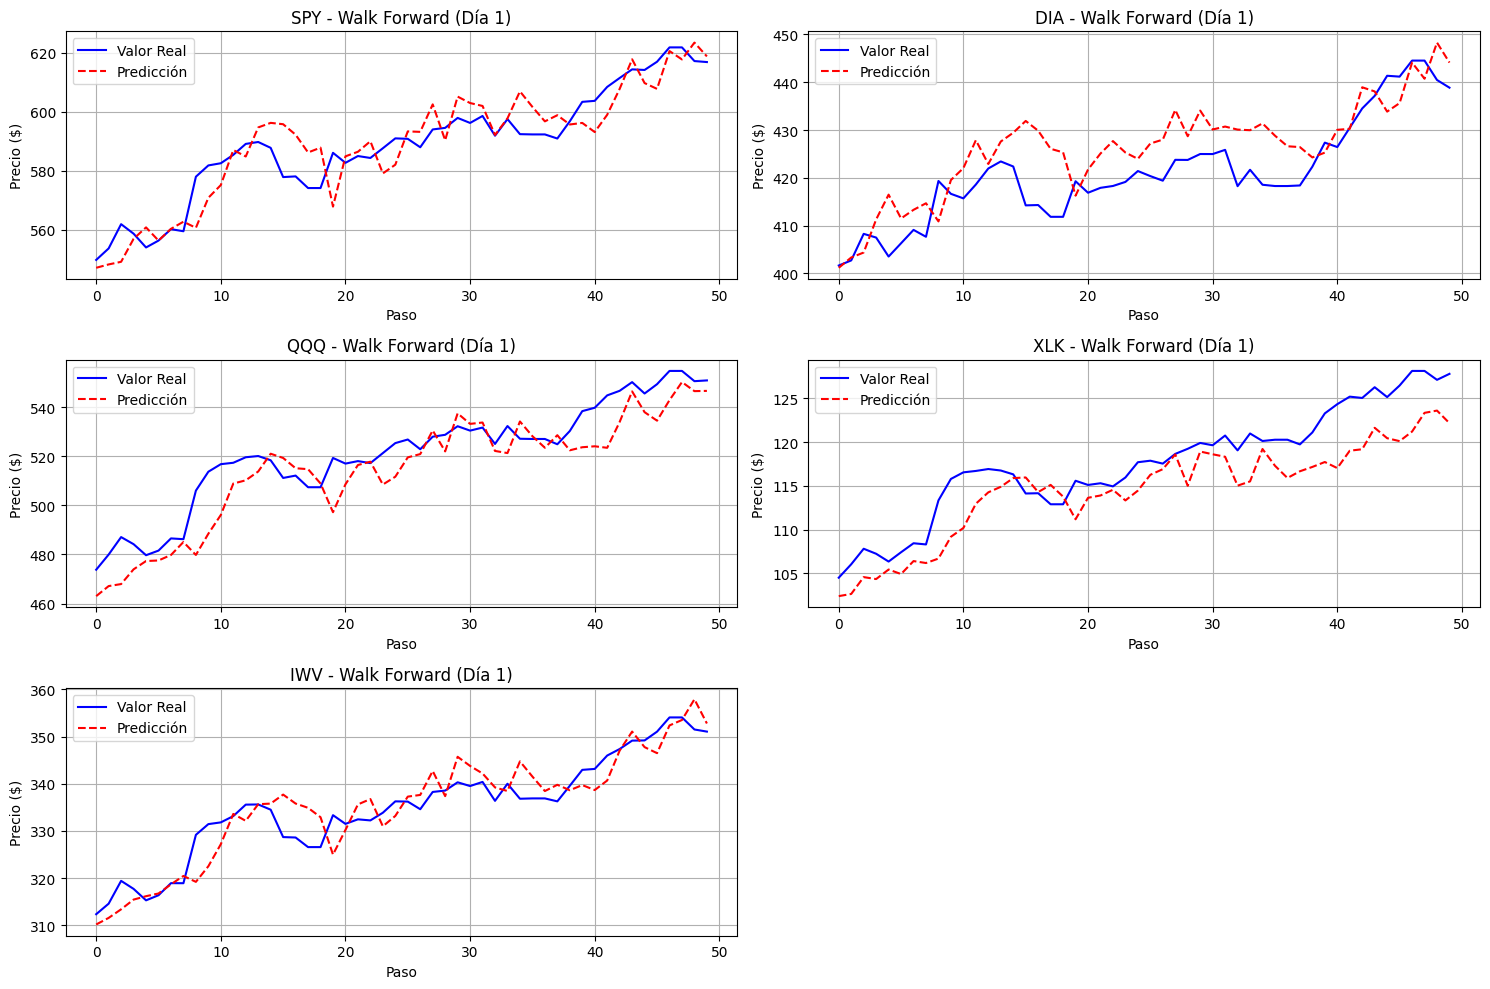

ERRORES POR ETF

SPY:
  Error promedio: $-0.42
  Error máximo: $18.23
  Error mínimo: $-17.91

DIA:
  Error promedio: $-5.07
  Error máximo: $8.45
  Error mínimo: $-17.66

QQQ:
  Error promedio: $6.63
  Error máximo: $26.24
  Error mínimo: $-8.15

XLK:
  Error promedio: $3.06
  Error máximo: $7.30
  Error mínimo: $-2.21

IWV:
  Error promedio: $-0.24
  Error máximo: $9.96
  Error mínimo: $-9.00


In [62]:
# Grafica simple para TODOS los ETFs
import matplotlib.pyplot as plt

# Lista de nombres de ETFs
nombres_etfs = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']

# Crear 5 graficas, una para cada ETF
plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(3, 2, i+1)
    
    # Graficar valores reales
    plt.plot(actuals_wf_ft[:, i], label='Valor Real', color='blue')
    
    # Graficar predicciones
    plt.plot(preds_wf_ft[:, i], label='Predicción', color='red', linestyle='--')
    
    # Titulos y etiquetas
    plt.title(f'{nombres_etfs[i]} - Walk Forward (Día 1)')
    plt.xlabel('Paso')
    plt.ylabel('Precio ($)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calcular errores para cada ETF
print("="*50)
print("ERRORES POR ETF")
print("="*50)
for i in range(5):
    error = actuals_wf_ft[:, i] - preds_wf_ft[:, i]
    print(f"\n{nombres_etfs[i]}:")
    print(f"  Error promedio: ${error.mean():.2f}")
    print(f"  Error máximo: ${error.max():.2f}")
    print(f"  Error mínimo: ${error.min():.2f}")

MÉTRICAS DE DESEMPEÑO POR ETF - WALK FORWARD (Día 1)
        MAE     RMSE      R²    MAPE
SPY  6.5485   8.1035  0.8065  0.0112
DIA  6.4904   7.6889  0.4715  0.0155
QQQ  8.5449  10.7951  0.7361  0.0164
XLK  3.2624   3.8382  0.6156  0.0274
IWV  3.5020   4.3793  0.8261  0.0105

MÉTRICAS PROMEDIO (todos los ETFs):
----------------------------------------------------------------------
MAE       :     5.6696
RMSE      :     6.9610
R²        :     0.6912
MAPE      :     0.0162 (1.62%)
----------------------------------------------------------------------


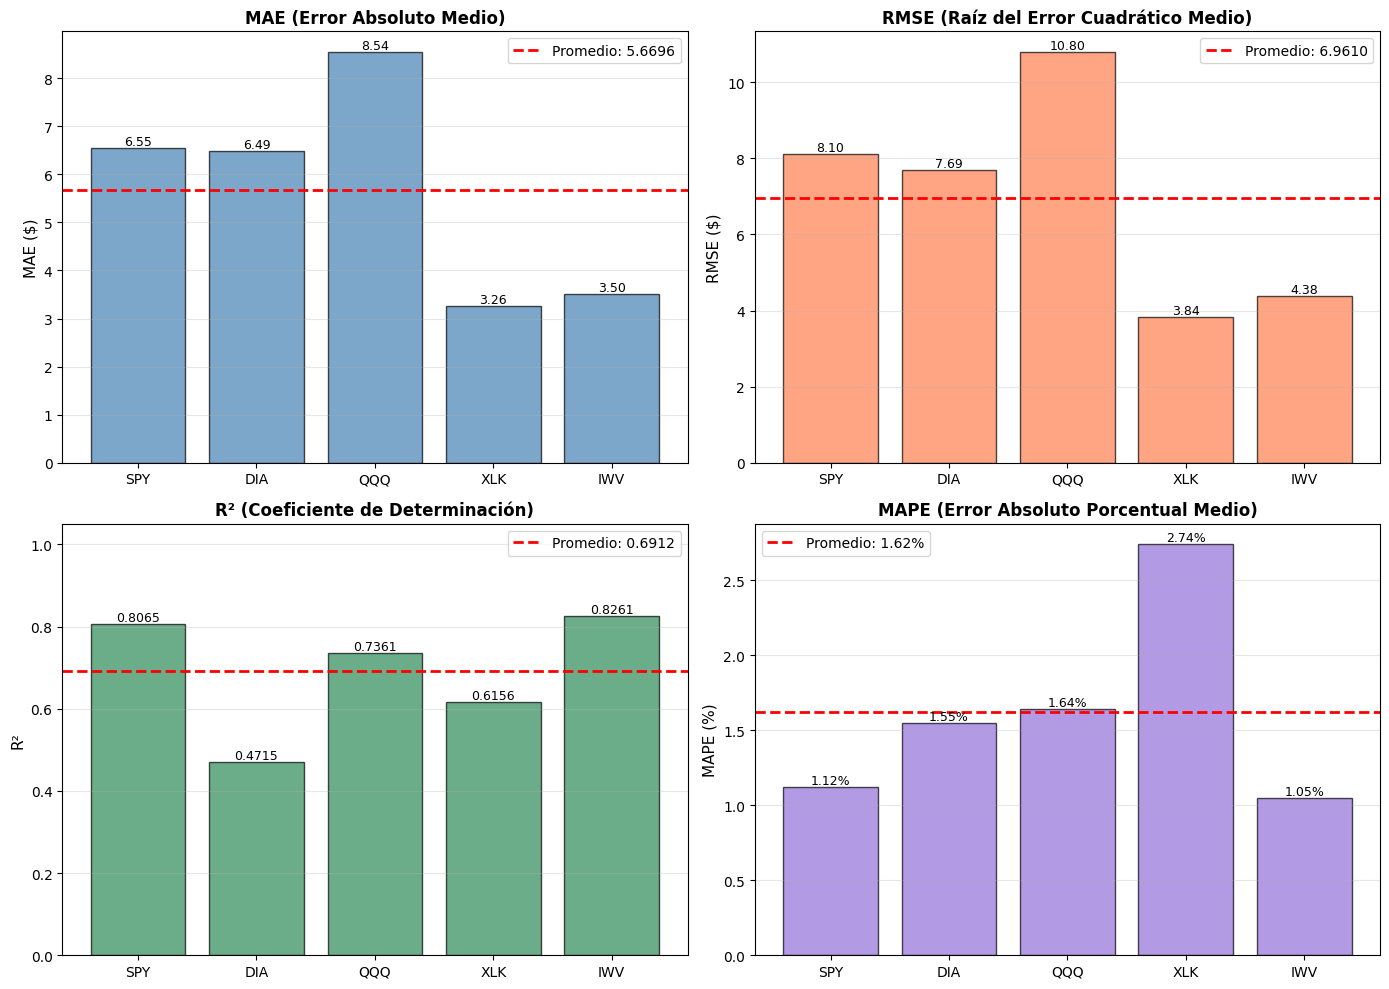


✓ Análisis de métricas completado.


In [63]:
# MÉTRICAS PROMEDIO - VISUALIZACIÓN COMPARATIVA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Nombres de ETFs
nombres_etfs = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']

# Calcular métricas para cada ETF
metricas_por_etf = {}

for i, etf in enumerate(nombres_etfs):
    y_true = actuals_wf_ft[:, i]
    y_pred = preds_wf_ft[:, i]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    metricas_por_etf[etf] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

# Crear DataFrame con las métricas
df_metricas = pd.DataFrame(metricas_por_etf).T
df_metricas = df_metricas.round(4)

print("="*70)
print("MÉTRICAS DE DESEMPEÑO POR ETF - WALK FORWARD (Día 1)")
print("="*70)
print(df_metricas)
print("="*70)

# Calcular promedios
promedios = df_metricas.mean()
print("\nMÉTRICAS PROMEDIO (todos los ETFs):")
print("-"*70)
for metrica in ['MAE', 'RMSE', 'R²', 'MAPE']:
    print(f"{metrica:10s}: {promedios[metrica]:10.4f}", end="")
    if metrica == 'MAPE':
        print(f" ({promedios[metrica]*100:.2f}%)")
    else:
        print()
print("-"*70)

# Visualizar métricas en gráficas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfica 1: MAE
ax = axes[0, 0]
bars1 = ax.bar(nombres_etfs, df_metricas['MAE'], color='steelblue', alpha=0.7, edgecolor='black')
ax.axhline(y=promedios['MAE'], color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedios["MAE"]:.4f}')
ax.set_title('MAE (Error Absoluto Medio)', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE ($)', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Gráfica 2: RMSE
ax = axes[0, 1]
bars2 = ax.bar(nombres_etfs, df_metricas['RMSE'], color='coral', alpha=0.7, edgecolor='black')
ax.axhline(y=promedios['RMSE'], color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedios["RMSE"]:.4f}')
ax.set_title('RMSE (Raíz del Error Cuadrático Medio)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE ($)', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Gráfica 3: R²
ax = axes[1, 0]
bars3 = ax.bar(nombres_etfs, df_metricas['R²'], color='seagreen', alpha=0.7, edgecolor='black')
ax.axhline(y=promedios['R²'], color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedios["R²"]:.4f}')
ax.set_title('R² (Coeficiente de Determinación)', fontsize=12, fontweight='bold')
ax.set_ylabel('R²', fontsize=11)
ax.set_ylim([min(df_metricas['R²'].min() - 0.01, 0), 1.05])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Gráfica 4: MAPE
ax = axes[1, 1]
mape_percent = df_metricas['MAPE'] * 100
bars4 = ax.bar(nombres_etfs, mape_percent, color='mediumpurple', alpha=0.7, edgecolor='black')
ax.axhline(y=promedios['MAPE']*100, color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedios["MAPE"]*100:.2f}%')
ax.set_title('MAPE (Error Absoluto Porcentual Medio)', fontsize=12, fontweight='bold')
ax.set_ylabel('MAPE (%)', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de métricas completado.")

## 9.3 EJEMPLO DE PREDICCIONES

In [40]:
# PREDICCIÓN SI EL CLIENTE ENTRA EL DÍA 22/01/2026 (PRÓXIMOS 5 DÍAS LABORABLES)

# Definir la fecha de referencia
fecha_prediccion = pd.to_datetime('2026-01-22')

# Filtrar datos hasta la fecha de referencia
df_hasta_fecha = df[df['Date'] <= fecha_prediccion].copy()

# Obtener los últimos 30 días
datos_30_dias = df_hasta_fecha.tail(30)

print("="*70)
print("PREDICCIÓN PARA 22/01/2026")
print("="*70)
print(f"\nÚltima fecha en datos: {df_hasta_fecha['Date'].max().date()}")
print(f"Días usados para predicción: {len(datos_30_dias)}")

# Preparar la ventana de 30 días
X_prediccion = datos_30_dias[feature_cols].values
X_prediccion = X_prediccion.reshape(1, 30, len(feature_cols))

# Diccionario para almacenar predicciones
predicciones_24_01 = {}
nombres_etfs = ['SPY', 'DIA', 'QQQ', 'XLK', 'IWV']

# Hacer predicción para cada horizonte (1 a 5 días)
print("\n" + "="*70)
print("REALIZANDO PREDICCIONES CON LOS 5 MODELOS")
print("="*70)

for dia in range(1, 6):
    print(f"\nDía {dia}:")
    
    # Cargar scaler y modelo
    scaler_X = modelos_guardados[dia-1]['scaler_X']
    scaler_y = modelos_guardados[dia-1]['scaler_y']
    modelo = modelos_guardados[dia-1]['modelo']
    
    # Normalizar los 30 días
    X_escalado = scaler_X.transform(X_prediccion.reshape(-1, len(feature_cols))).reshape(X_prediccion.shape)
    
    # Hacer predicción
    pred_escalada = modelo.predict(X_escalado, verbose=0)
    
    # Desnormalizar
    prediccion = scaler_y.inverse_transform(pred_escalada)
    
    # Almacenar
    predicciones_24_01[dia] = prediccion[0]
    
    # Mostrar predicciones para cada ETF
    print("-"*70)
    for j, etf in enumerate(nombres_etfs):
        print(f"  {etf}: ${prediccion[0, j]:.2f}")

# Crear tabla de resumen (SOLO DÍAS LABORABLES - Sin fines de semana)
print("\n" + "="*70)
print("TABLA RESUMEN DE PREDICCIONES (SOLO DÍAS LABORABLES)")
print("="*70)

data_tabla = []
# Generar días laborables (freq='B' = Business days, lunes-viernes)
fechas_predichas = pd.bdate_range(start='2026-01-23', periods=5)

for dia, fecha in enumerate(fechas_predichas, 1):
    row = {'Fecha': fecha.date()}
    for j, etf in enumerate(nombres_etfs):
        row[etf] = predicciones_24_01[dia][j]
    data_tabla.append(row)

df_predicciones = pd.DataFrame(data_tabla)
display(df_predicciones)

print("\n✓ Predicciones completadas")

PREDICCIÓN PARA 22/01/2026

Última fecha en datos: 2026-01-20
Días usados para predicción: 30

REALIZANDO PREDICCIONES CON LOS 5 MODELOS

Día 1:
----------------------------------------------------------------------
  SPY: $641.95
  DIA: $457.82
  QQQ: $553.58
  XLK: $130.13
  IWV: $361.89

Día 2:
----------------------------------------------------------------------
  SPY: $659.47
  DIA: $447.10
  QQQ: $566.88
  XLK: $136.46
  IWV: $373.10

Día 3:
----------------------------------------------------------------------
  SPY: $664.58
  DIA: $433.88
  QQQ: $555.20
  XLK: $132.39
  IWV: $370.74

Día 4:
----------------------------------------------------------------------
  SPY: $677.46
  DIA: $450.40
  QQQ: $564.47
  XLK: $133.91
  IWV: $363.89

Día 5:
----------------------------------------------------------------------
  SPY: $654.09
  DIA: $460.86
  QQQ: $566.82
  XLK: $130.88
  IWV: $369.72

TABLA RESUMEN DE PREDICCIONES (SOLO DÍAS LABORABLES)


,Fecha,SPY,DIA,QQQ,XLK,IWV
0,2026-01-23,641.950073,457.819092,553.579041,130.133240,361.893433
1,2026-01-26,659.466370,447.103668,566.875305,136.456650,373.101318
2,2026-01-27,664.576538,433.876587,555.197510,132.385162,370.738068
3,2026-01-28,677.458191,450.404205,564.465881,133.909195,363.889496
4,2026-01-29,654.086121,460.860687,566.824402,130.879608,369.715698



✓ Predicciones completadas
